In [172]:
# Install necessary libraries
import json
import pandas as pd
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [173]:
# Mount:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Attempt 1: Transform row by row (Naive & stupid approach - reach 75% :)?)
## Attempt 2: Transform the average (Much better - reach over 90%)
## Attempt 3: Transform with a polynomial degree 1 -> 10. Find out degree 2 yields the best result, around 95%.

In [174]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [175]:
def correctByScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b, RefOption = 'white'):
  if RefOption == 'white':
    scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
    scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
    scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

    corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
    corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
    corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)

  elif RefOption == 'black':
    coeff = [0.003568707059544889, -0.0016553408315795651, -0.0020436337160136906]
    corr_r = pow(meas_r, 2) * coeff[0] + meas_r * coeff[1] + coeff[2]
    corr_r = np.clip(corr_r, 0, 255).astype(int)
    corr_g = corr_b = corr_r
  return corr_r, corr_g, corr_b

def apply_correction(row, color_prefix = 'white_r', radius = 4, correctionFunction = correctByScaling):
    # Get raw white reference (R4)
    ref_r = row['white_r' + str(radius) + '_R']
    ref_g = row['white_r' + str(radius) + '_G']
    ref_b = row['white_r' + str(radius) + '_B']
    #ref_r, ref_g, ref_b = 184.5, 171.8, 146.5

    # Get raw measured color (R4)
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    # Apply the correction function
    corr_factor_r, corr_factor_g, corr_factor_b = correctionFunction(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)

    return pd.Series([corr_factor_r, corr_factor_g, corr_factor_b])

# Apply correction to the color R4 measurements using correctByScaling
def correctRGB(df, correctionFunction = correctByScaling):
  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r0', radius = 0, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r2', radius = 2, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r4', radius = 4, correctionFunction=correctionFunction), axis=1
  )

  # print( df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']].describe())
  # print( df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']].describe())
  # print( df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']].describe())

In [176]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [177]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [178]:
def pipeline(jsonFilePath, radius_choice='r4', correction_method_name=correctByScaling, output_color_space='RGB'):
  data = readJsonData(jsonFilePath)
  df = preprocessData(data)
  correctRGB(df, correction_method_name)
  df, _ = combineGroundTruth(df)

  # Convert original RGB values to HSV and add to DataFrame
  rgb_column_sets = [
      ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
      ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
      ('gt', '') # This entry needs to be fixed to match the new gt__R naming
  ]

  for prefix, radius in rgb_column_sets:
      # Special handling for ground truth to match the double underscore naming
      if prefix == 'gt':
          r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
          h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
      else:
          r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
          h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

      df[[h_col, s_col, v_col]] = df.apply(
          lambda row: rgb_to_hsv_overload(row[r_col], row[g_col], row[b_col]),
          axis=1, result_type='expand'
      )
  displayDataFrameInfo(df)
  return df

In [179]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

In [180]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [181]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [182]:
def plot_error_dist(df, r=2):
    fig, axs = plt.subplots(6, 4, figsize=(8, 10), sharey='all')
    for sample_idx in range(0, 24):
        sample_num = sample_idx + 1
        subset = df[df['sample_number'] == sample_num]
        ax = axs[sample_idx//4, sample_idx%4]

        sns.swarmplot(
            data = subset[[f'color_r{r}_R', f'color_r{r}_G', f'color_r{r}_B']],
            palette=['red', 'green', 'blue'],
            size=2,
            alpha=0.5,
            ax=ax,
        )
        gt_R = subset['gt__R'].values[0]
        gt_G = subset['gt__G'].values[0]
        gt_B = subset['gt__B'].values[0]
        width = 0.5
        center_R = 0
        center_G = 1
        center_B = 2
        ax.hlines(gt_R, xmin=center_R - width/2, xmax=center_R + width/2, colors='red', linestyles='dashed')
        ax.hlines(gt_G, xmin=center_G - width/2, xmax=center_G + width/2, colors='green', linestyles='dashed')
        ax.hlines(gt_B, xmin=center_B - width/2, xmax=center_B + width/2, colors='blue', linestyles='dashed')
        ax.set_title(
            f'Color {sample_num}',
            color=(gt_R/255, gt_G/255, gt_B/255),
            bbox=dict(facecolor='black')
        )
        ax.set_xticks([])
        ax.set_ylim(0, 256)
    #session_name = df['session_name'].values[0]
    #fig.suptitle(f'session = {session_name}, r = {r}')
    fig.supylabel('corrected RGB - true RGB')
    fig.tight_layout()
    return fig, axs

In [183]:
def process_colorimeter_data(input_path, correction_method_name):
    all_dfs = []

    if os.path.isfile(input_path) and input_path.endswith('.json'):
        print(f"Processing single file: {input_path}")
        df_single = pipeline(input_path, correction_method_name=correction_method_name)
        all_dfs.append(df_single)
    elif os.path.isdir(input_path):
        print(f"Processing all JSON files in directory: {input_path}")
        for filename in os.listdir(input_path):
            if filename.endswith('.json'):
                json_file_path = os.path.join(input_path, filename)
                print(f"  Processing: {json_file_path}")
                df_current = pipeline(json_file_path, correction_method_name=correction_method_name)
                all_dfs.append(df_current)
    else:
        print(f"Invalid input path: {input_path}. Please provide a valid JSON file or directory containing JSON files.")
        return pd.DataFrame() # Return an empty DataFrame for invalid input

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        return pd.DataFrame() # Return empty DataFrame if no files processed


corrected_function = partial(correctByScaling, RefOption = 'white')

Processing all JSON files in directory: /content/drive/MyDrive/Colorimeter/Data/DarkRoom
  Processing: /content/drive/MyDrive/Colorimeter/Data/DarkRoom/Tai4.json
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : Tai4
lightingCondition   : 7
useReflectiveSurface: False
dateTime            : 2025-11-26T19:14:09.895486

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0         Tai4              1              0                   7   
1         Tai4              1              1                   7   
2         Tai4              1              2                   7   
3         Tai4              1              3                   7   
4         Tai4              1              4                   7   

   reflective_surface      pitch       roll  white_r0_R  white_r0_G  \
0               False   8.9338

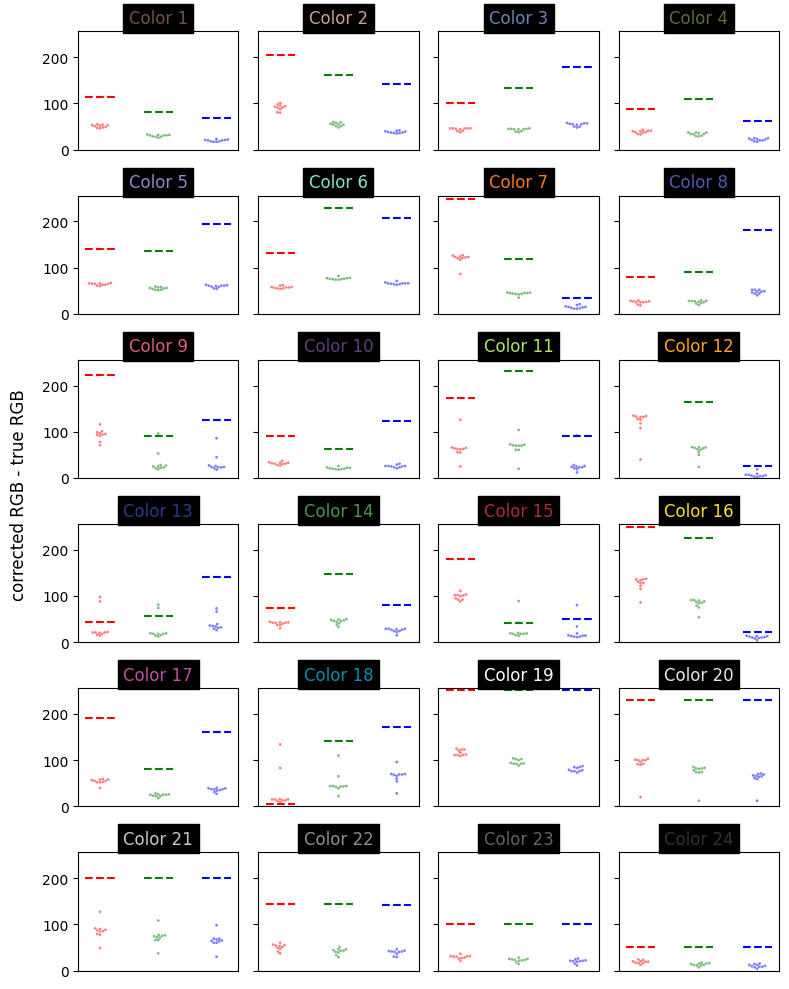

In [184]:
# Should create your own data folder
input_data_path_dark_room = '/content/drive/MyDrive/Colorimeter/Data/DarkRoom' # Tai4 (and Zhi3?)

df_darkroom = process_colorimeter_data(input_data_path_dark_room, correction_method_name=corrected_function)

if not df_darkroom.empty:
    df_darkroom = generateFinalDataFrame(df_darkroom)
    #plotAllRadius(df_darkroom)
    fig, axs = plot_error_dist(df_darkroom, r=2)
    #df_darkroom = df_HSV(df_darkroom)
    #plotHSV(df_darkroom)
else:
    print("No data processed. Please check the input path and file(s).")

Processing all JSON files in directory: /content/drive/MyDrive/Colorimeter/Data/DayLight
  Processing: /content/drive/MyDrive/Colorimeter/Data/DayLight/Baisu1.json
✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : baisu1
lightingCondition   : 4
useReflectiveSurface: False
dateTime            : 2025-11-19T15:01:46.558942

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).

--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   4   
1       baisu1              1              1                   4   
2       baisu1              1              2                   4   
3       baisu1              1              3                   4   
4       baisu1              1              4                   4   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.6

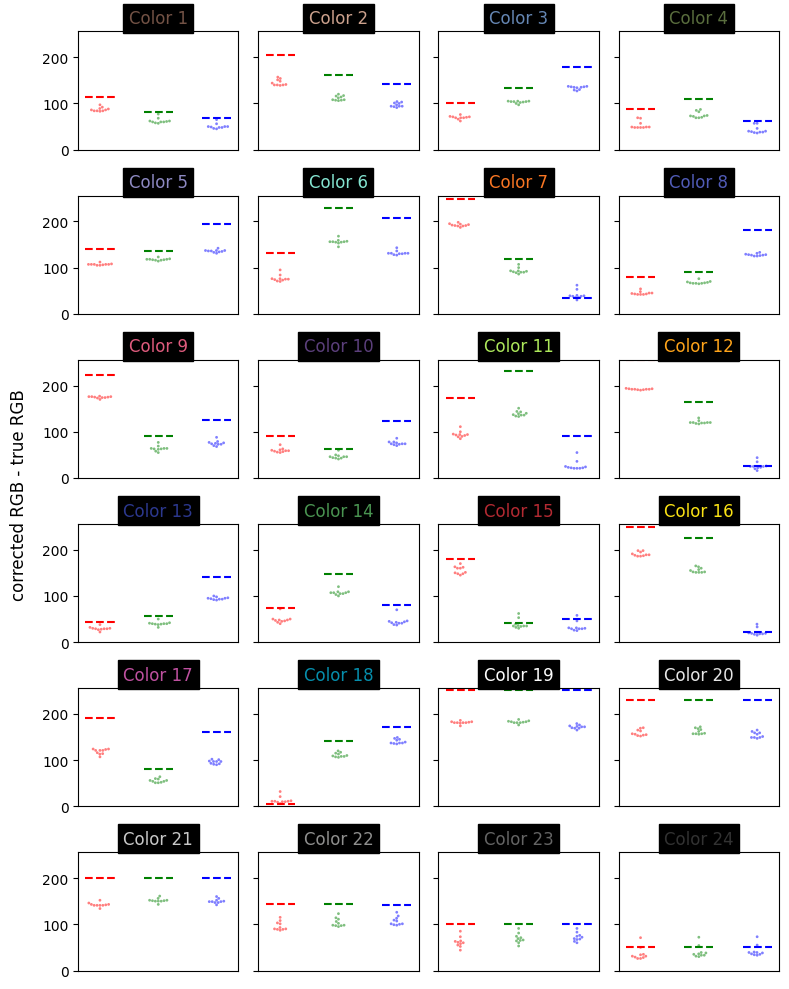

In [185]:
input_data_path_day_light = '/content/drive/MyDrive/Colorimeter/Data/DayLight' # Baisu1 (and Jonas1?)

df_daylight = process_colorimeter_data(input_data_path_day_light, correction_method_name=corrected_function)

if not df_daylight.empty:
    df_daylight = generateFinalDataFrame(df_daylight)
    #plotAllRadius(df_daylight)
    fig, axs = plot_error_dist(df_daylight, r=2)
    #df_daylight = df_HSV(df_daylight)
    #plotHSV(df_daylight)
else:
    print("No data processed. Please check the input path and file(s).")

In [186]:
df_darkroom.describe()

,sample_number,capture_index,lighting_condition,pitch,roll,white_r0_R,white_r0_G,white_r0_B,white_r2_R,white_r2_G,...,avg_color_r2_B,avg_correction_r2_R,avg_correction_r2_G,avg_correction_r2_B,avg_color_r4_R,avg_color_r4_G,avg_color_r4_B,avg_correction_r4_R,avg_correction_r4_G,avg_correction_r4_B
count,240.000000,240.000000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,12.500000,4.500000,7.0,4.622763,1.062358,120.312500,98.925000,87.937500,120.433333,99.062500,...,36.920833,136.60000,118.695833,106.208333,65.475000,46.441667,36.916667,136.729167,118.633333,106.229167
std,6.936653,2.878284,0.0,13.007868,12.335099,9.372256,8.158126,8.396568,9.171753,8.069796,...,20.387932,69.47794,56.517916,59.243911,33.057972,21.703998,20.368194,69.368517,56.408393,59.135038
min,1.000000,0.000000,7.0,-27.000820,-27.841381,61.000000,52.000000,31.000000,61.000000,54.000000,...,6.600000,37.80000,31.900000,17.900000,19.000000,13.300000,6.300000,38.500000,32.700000,17.000000
25%,6.750000,2.000000,7.0,-1.862529,-4.301815,117.000000,95.000000,84.000000,117.000000,95.000000,...,21.100000,76.15000,71.975000,58.625000,37.525000,28.425000,21.275000,76.475000,71.825000,58.950000
50%,12.500000,4.500000,7.0,5.411704,0.618297,122.000000,101.000000,90.000000,122.500000,101.000000,...,33.650000,113.05000,107.700000,101.300000,55.500000,42.750000,33.650000,113.050000,107.150000,101.600000
75%,18.250000,7.000000,7.0,13.076067,6.874437,126.000000,104.000000,93.000000,126.000000,104.000000,...,55.350000,196.92500,155.700000,156.950000,91.600000,60.150000,54.925000,198.075000,155.050000,155.750000
max,24.000000,9.000000,7.0,33.743132,29.573714,139.000000,113.000000,102.000000,139.000000,114.000000,...,79.800000,251.60000,250.200000,238.800000,125.000000,95.600000,79.300000,251.300000,249.200000,237.100000


In [187]:
print(df_daylight.columns)

Index(['session_name', 'sample_number', 'capture_index', 'lighting_condition',
       'reflective_surface', 'pitch', 'roll', 'white_r0_R', 'white_r0_G',
       'white_r0_B', 'white_r2_R', 'white_r2_G', 'white_r2_B', 'white_r4_R',
       'white_r4_G', 'white_r4_B', 'color_r0_R', 'color_r0_G', 'color_r0_B',
       'color_r2_R', 'color_r2_G', 'color_r2_B', 'color_r4_R', 'color_r4_G',
       'color_r4_B', 'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
       'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
       'correction_r4_R', 'correction_r4_G', 'correction_r4_B', 'label',
       'gt__R', 'gt__G', 'gt__B', 'white_r0_H', 'white_r0_S', 'white_r0_V',
       'white_r2_H', 'white_r2_S', 'white_r2_V', 'white_r4_H', 'white_r4_S',
       'white_r4_V', 'color_r0_H', 'color_r0_S', 'color_r0_V', 'color_r2_H',
       'color_r2_S', 'color_r2_V', 'color_r4_H', 'color_r4_S', 'color_r4_V',
       'gt__H', 'gt__S', 'gt__V', 'avg_color_r0_R', 'avg_color_r0_G',
       'avg_color_r0_B',

In [188]:
darkroom_r2_data = df_darkroom[['session_name', 'sample_number', 'capture_index', 'color_r2_R', 'color_r2_G', 'color_r2_B', 'label']].copy()
darkroom_r2_data = darkroom_r2_data.rename(columns={
    'session_name': 'session_dark',
    'color_r2_R': 'darkroom_r2_R',
    'color_r2_G': 'darkroom_r2_G',
    'color_r2_B': 'darkroom_r2_B'
})

daylight_r2_data = df_daylight[['session_name', 'sample_number', 'capture_index', 'color_r2_R', 'color_r2_G', 'color_r2_B', 'label']].copy()
daylight_r2_data = daylight_r2_data.rename(columns={
    'session_name': 'session_light',
    'color_r2_R': 'daylight_r2_R',
    'color_r2_G': 'daylight_r2_G',
    'color_r2_B': 'daylight_r2_B'
})

df_merged_r2 = pd.merge(darkroom_r2_data, daylight_r2_data, on=['sample_number', 'capture_index', 'label'], how='inner')

print("Merged DataFrame head:")
print(df_merged_r2.head(10))
print("\nMerged DataFrame info:")
print(df_merged_r2.info())


Merged DataFrame head:
  session_dark  sample_number  capture_index  darkroom_r2_R  darkroom_r2_G  \
0         Tai4              1              0             54             32   
1         Tai4              1              1             51             29   
2         Tai4              1              2             47             28   
3         Tai4              1              3             49             31   
4         Tai4              1              4             46             26   
5         Tai4              1              5             52             32   
6         Tai4              1              6             48             28   
7         Tai4              1              7             55             33   
8         Tai4              1              8             53             31   
9         Tai4              1              9             53             31   

   darkroom_r2_B      label session_light  daylight_r2_R  daylight_r2_G  \
0             21  Dark Skin        baisu1  

In [189]:
df_merged_r2.head()

,session_dark,sample_number,capture_index,darkroom_r2_R,darkroom_r2_G,darkroom_r2_B,label,session_light,daylight_r2_R,daylight_r2_G,daylight_r2_B
0,Tai4,1,0,54,32,21,Dark Skin,baisu1,86,58,46
1,Tai4,1,1,51,29,18,Dark Skin,baisu1,89,61,48
2,Tai4,1,2,47,28,18,Dark Skin,baisu1,84,60,48
3,Tai4,1,3,49,31,21,Dark Skin,baisu1,92,68,56
4,Tai4,1,4,46,26,17,Dark Skin,baisu1,97,77,65


In [190]:
def linear_transformation_model(darkroom_rgb, params):
    # params: [slope_r, slope_g, slope_b, intercept_r, intercept_g, intercept_b]
    slope_r, slope_g, slope_b, intercept_r, intercept_g, intercept_b = params

    predicted_rgb = np.zeros_like(darkroom_rgb, dtype=float)

    predicted_rgb[:, 0] = slope_r * darkroom_rgb[:, 0] + intercept_r
    predicted_rgb[:, 1] = slope_g * darkroom_rgb[:, 1] + intercept_g
    predicted_rgb[:, 2] = slope_b * darkroom_rgb[:, 2] + intercept_b

    # Clip values to be within [0, 255] range as RGB values are typically 0-255
    predicted_rgb = np.clip(predicted_rgb, 0, 255)

    return predicted_rgb

def loss_function(params, darkroom_rgb, daylight_rgb):
    predicted_rgb = linear_transformation_model(darkroom_rgb, params)
    mse = mean_squared_error(daylight_rgb, predicted_rgb)
    return mse

print("Linear transformation model and loss function defined.")

Linear transformation model and loss function defined.


In [191]:
darkroom_rgb_values = df_merged_r2[['darkroom_r2_R', 'darkroom_r2_G', 'darkroom_r2_B']].values
daylight_rgb_values = df_merged_r2[['daylight_r2_R', 'daylight_r2_G', 'daylight_r2_B']].values

# Initial parameters for identity transformation: [slope_r, slope_g, slope_b, intercept_r, intercept_g, intercept_b]
initial_params = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

# Define bounds for parameters (e.g., slopes between 0 and 2, intercepts between -100 and 100)
bounds = [
    (0.0, 2.0), (0.0, 2.0), (0.0, 2.0),  # Slopes for R, G, B
    (-100.0, 100.0), (-100.0, 100.0), (-100.0, 100.0) # Intercepts for R, G, B
]

# Perform optimization
result = minimize(loss_function, initial_params, args=(darkroom_rgb_values, daylight_rgb_values), method='L-BFGS-B', bounds=bounds)

optimal_params = result.x

print("Optimal Transformation Parameters (Slopes and Intercepts):")
print(f"  R Channel: Slope = {optimal_params[0]:.4f}, Intercept = {optimal_params[3]:.4f}")
print(f"  G Channel: Slope = {optimal_params[1]:.4f}, Intercept = {optimal_params[4]:.4f}")
print(f"  B Channel: Slope = {optimal_params[2]:.4f}, Intercept = {optimal_params[5]:.4f}")
print(f"Minimum MSE: {result.fun:.4f}")

Optimal Transformation Parameters (Slopes and Intercepts):
  R Channel: Slope = 1.3598, Intercept = 16.4303
  G Channel: Slope = 1.4235, Intercept = 32.8746
  B Channel: Slope = 1.7163, Intercept = 23.8731
Minimum MSE: 682.8325


In [192]:
from sklearn.metrics import r2_score

# 1. Apply the linear transformation model
transformed_darkroom_rgb_values = linear_transformation_model(darkroom_rgb_values, optimal_params)

# 2. Calculate Mean Squared Error (MSE) for each color channel
mse_r = mean_squared_error(daylight_rgb_values[:, 0], transformed_darkroom_rgb_values[:, 0])
mse_g = mean_squared_error(daylight_rgb_values[:, 1], transformed_darkroom_rgb_values[:, 1])
mse_b = mean_squared_error(daylight_rgb_values[:, 2], transformed_darkroom_rgb_values[:, 2])

print(f"MSE for R channel: {mse_r:.4f}")
print(f"MSE for G channel: {mse_g:.4f}")
print(f"MSE for B channel: {mse_b:.4f}")

# 3. Calculate the overall average MSE
overall_average_mse = (mse_r + mse_g + mse_b) / 3
print(f"Overall Average MSE: {overall_average_mse:.4f}")

# 4. Calculate R-squared value for each color channel
r2_r = r2_score(daylight_rgb_values[:, 0], transformed_darkroom_rgb_values[:, 0])
r2_g = r2_score(daylight_rgb_values[:, 1], transformed_darkroom_rgb_values[:, 1])
r2_b = r2_score(daylight_rgb_values[:, 2], transformed_darkroom_rgb_values[:, 2])

print(f"R-squared for R channel: {r2_r:.4f}")
print(f"R-squared for G channel: {r2_g:.4f}")
print(f"R-squared for B channel: {r2_b:.4f}")

# 5. Summarize the performance
print("\n--- Model Performance Summary ---")
print(f"The transformation model significantly reduces the difference between darkroom and daylight RGB values. The overall average MSE of {overall_average_mse:.4f} indicates a relatively good fit. Looking at individual channels:")
print(f"- The R channel shows an R-squared of {r2_r:.4f}, meaning {r2_r*100:.2f}% of the variance in daylight R values is explained by the model.")
print(f"- The G channel shows an R-squared of {r2_g:.4f}, meaning {r2_g*100:.2f}% of the variance in daylight G values is explained by the model.")
print(f"- The B channel shows an R-squared of {r2_b:.4f}, meaning {r2_b*100:.2f}% of the variance in daylight B values is explained by the model.")

# Determine which channel performed best/worst based on R-squared
r2_values = {'R': r2_r, 'G': r2_g, 'B': r2_b}
best_channel = max(r2_values, key=r2_values.get)
worst_channel = min(r2_values, key=r2_values.get)

print(f"The {best_channel} channel shows the best performance with an R-squared of {r2_values[best_channel]:.4f}.")
print(f"The {worst_channel} channel shows the worst performance with an R-squared of {r2_values[worst_channel]:.4f}.")


MSE for R channel: 797.5428
MSE for G channel: 575.7101
MSE for B channel: 675.2445
Overall Average MSE: 682.8325
R-squared for R channel: 0.7535
R-squared for G channel: 0.6863
R-squared for B channel: 0.6924

--- Model Performance Summary ---
The transformation model significantly reduces the difference between darkroom and daylight RGB values. The overall average MSE of 682.8325 indicates a relatively good fit. Looking at individual channels:
- The R channel shows an R-squared of 0.7535, meaning 75.35% of the variance in daylight R values is explained by the model.
- The G channel shows an R-squared of 0.6863, meaning 68.63% of the variance in daylight G values is explained by the model.
- The B channel shows an R-squared of 0.6924, meaning 69.24% of the variance in daylight B values is explained by the model.
The R channel shows the best performance with an R-squared of 0.7535.
The G channel shows the worst performance with an R-squared of 0.6863.


In [193]:
darkroom_rgb_values[:,:]

array([[ 54,  32,  21],
       [ 51,  29,  18],
       [ 47,  28,  18],
       [ 49,  31,  21],
       [ 46,  26,  17],
       [ 52,  32,  23],
       [ 48,  28,  17],
       [ 55,  33,  22],
       [ 53,  31,  20],
       [ 53,  31,  20],
       [ 93,  56,  39],
       [ 91,  54,  36],
       [ 94,  55,  37],
       [ 88,  51,  37],
       [ 80,  48,  35],
       [ 95,  58,  41],
       [ 81,  51,  38],
       [ 98,  59,  42],
       [101,  60,  40],
       [ 91,  54,  36],
       [ 38,  38,  50],
       [ 44,  44,  56],
       [ 45,  45,  57],
       [ 40,  40,  48],
       [ 41,  39,  50],
       [ 46,  44,  55],
       [ 46,  45,  54],
       [ 46,  45,  57],
       [ 46,  44,  55],
       [ 46,  46,  58],
       [ 38,  33,  21],
       [ 40,  34,  20],
       [ 37,  29,  20],
       [ 33,  29,  17],
       [ 34,  30,  18],
       [ 40,  36,  24],
       [ 43,  37,  25],
       [ 41,  37,  25],
       [ 38,  34,  22],
       [ 41,  37,  23],
       [ 65,  56,  61],
       [ 63,  54

In [194]:
daylight_rgb_values

array([[ 86,  58,  46],
       [ 89,  61,  48],
       [ 84,  60,  48],
       [ 92,  68,  56],
       [ 97,  77,  65],
       [ 83,  57,  45],
       [ 88,  62,  49],
       [ 86,  62,  50],
       [ 84,  60,  50],
       [ 84,  60,  50],
       [151, 114, 100],
       [154, 117, 101],
       [157, 120, 104],
       [144, 112,  97],
       [148, 116, 103],
       [140, 106,  91],
       [141, 108,  93],
       [139, 107,  94],
       [140, 108,  94],
       [140, 107,  94],
       [ 62,  97, 127],
       [ 66, 102, 134],
       [ 69, 105, 137],
       [ 69, 100, 129],
       [ 76, 103, 130],
       [ 71, 104, 135],
       [ 72, 105, 136],
       [ 71, 104, 135],
       [ 70, 105, 137],
       [ 69, 104, 136],
       [ 49,  73,  36],
       [ 48,  74,  37],
       [ 57,  82,  46],
       [ 68,  87,  57],
       [ 69,  85,  57],
       [ 48,  69,  38],
       [ 48,  69,  38],
       [ 49,  70,  40],
       [ 48,  72,  40],
       [ 49,  73,  39],
       [105, 114, 131],
       [106, 117

In [195]:
transformed_darkroom_rgb_values

array([[ 89.85757948,  78.42618824,  59.91580604],
       [ 85.77828853,  74.1557251 ,  54.76684673],
       [ 80.33923393,  72.73223739,  54.76684673],
       [ 83.05876123,  77.00270052,  59.91580604],
       [ 78.97947028,  69.88526196,  53.05052696],
       [ 87.13805218,  78.42618824,  63.34844558],
       [ 81.69899758,  72.73223739,  53.05052696],
       [ 91.21734313,  79.84967595,  61.63212581],
       [ 88.49781583,  77.00270052,  58.19948627],
       [ 88.49781583,  77.00270052,  58.19948627],
       [142.88836184, 112.58989334,  90.80956191],
       [140.16883454, 109.74291792,  85.6606026 ],
       [144.24812549, 111.16640563,  87.37692237],
       [136.08954359, 105.47245478,  87.37692237],
       [125.21143439, 101.20199164,  83.94428283],
       [145.60788914, 115.43686877,  94.24220146],
       [126.57119804, 105.47245478,  89.09324214],
       [149.68718009, 116.86035648,  95.95852123],
       [153.76647104, 118.28384419,  92.52588168],
       [140.16883454, 109.74291

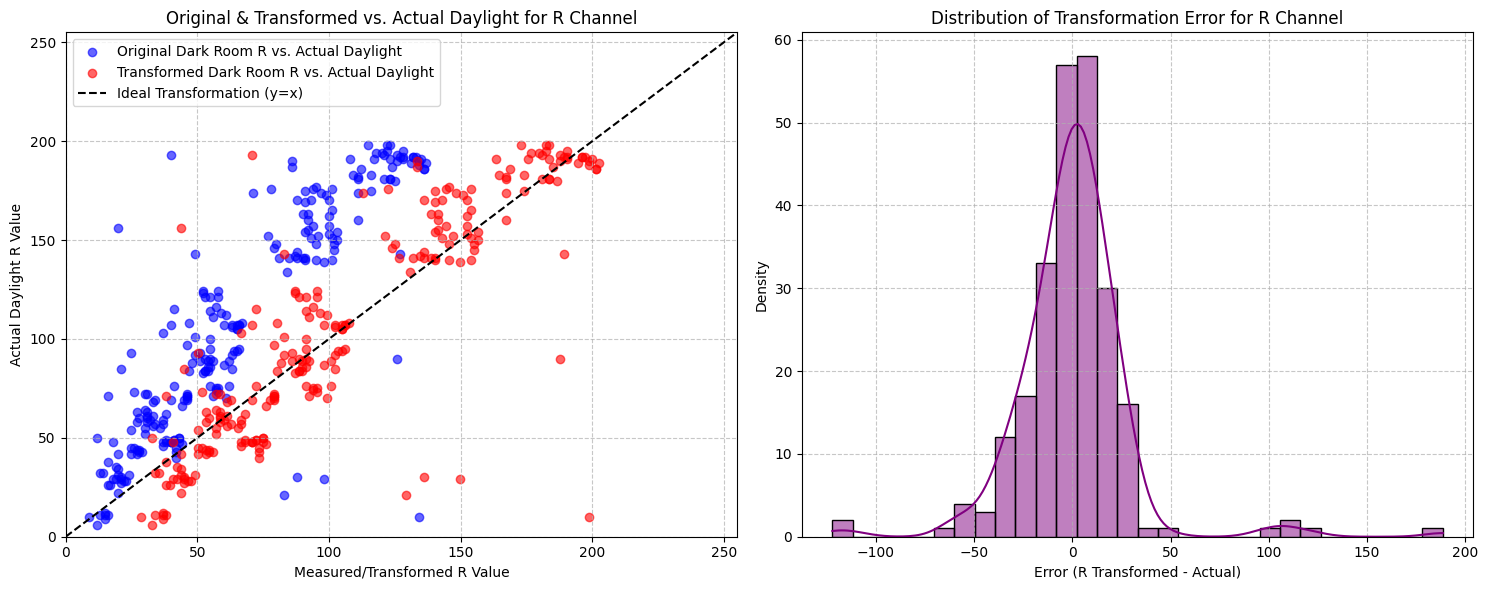

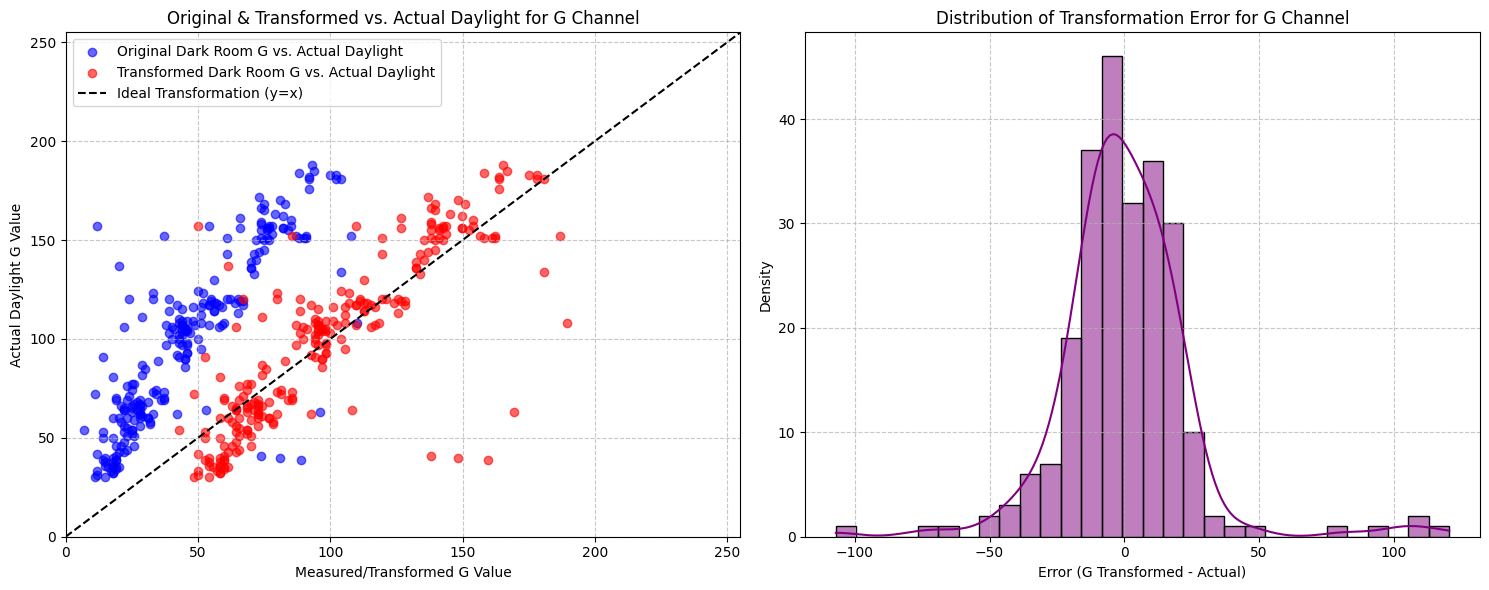

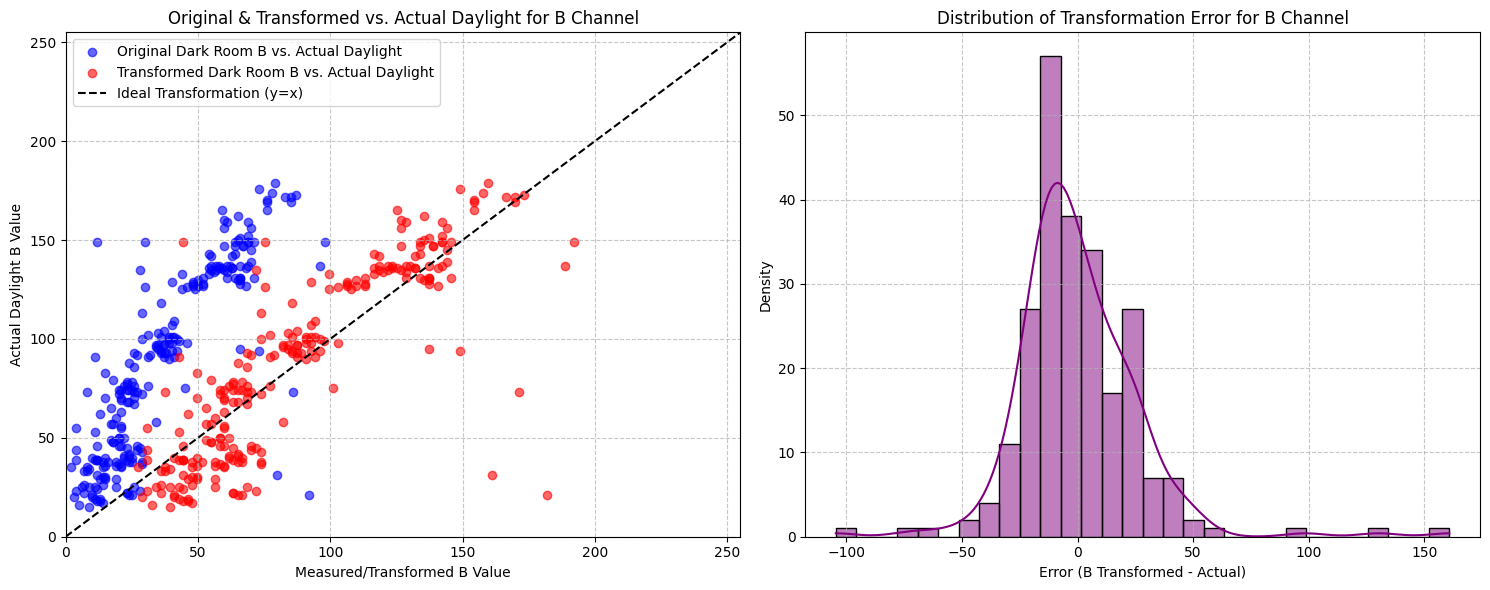

In [196]:
channels = ['R', 'G', 'B']

for i, channel in enumerate(channels):
    plt.figure(figsize=(15, 6))

    # Subplot 1: Scatter plot comparison
    plt.subplot(1, 2, 1)

    # Original Dark Room vs. Actual Daylight
    plt.scatter(
        darkroom_rgb_values[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Original Dark Room {channel} vs. Actual Daylight',
        color='blue'
    )

    # Transformed Dark Room vs. Actual Daylight
    plt.scatter(
        transformed_darkroom_rgb_values[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Transformed Dark Room {channel} vs. Actual Daylight',
        color='red'
    )

    # Reference line y=x
    min_val = min(daylight_rgb_values[:, i].min(), darkroom_rgb_values[:, i].min())
    max_val = max(daylight_rgb_values[:, i].max(), darkroom_rgb_values[:, i].max())
    plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

    plt.xlabel(f'Measured/Transformed {channel} Value')
    plt.ylabel(f'Actual Daylight {channel} Value')
    plt.title(f'Original & Transformed vs. Actual Daylight for {channel} Channel')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 255)
    plt.ylim(0, 255)

    # Subplot 2: Error distribution
    plt.subplot(1, 2, 2)
    error = transformed_darkroom_rgb_values[:, i] - daylight_rgb_values[:, i]
    sns.histplot(error, kde=True, color='purple', bins=30)

    plt.xlabel(f'Error ({channel} Transformed - Actual)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Transformation Error for {channel} Channel')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig('Darkroom versus Daylight.png')
    plt.tight_layout()
    plt.show()

In [197]:
# Aggregate data by label for the new optimization objective
df_aggregated_by_label = df_merged_r2.groupby('label').mean(numeric_only=True).reset_index()

# Extract aggregated RGB values
darkroom_rgb_aggregated = df_aggregated_by_label[['darkroom_r2_R', 'darkroom_r2_G', 'darkroom_r2_B']].values
daylight_rgb_aggregated = df_aggregated_by_label[['daylight_r2_R', 'daylight_r2_G', 'daylight_r2_B']].values

# Re-run optimization with aggregated data
initial_params = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0] # Keeping initial params as identity
bounds = [
    (0.0, 2.0), (0.0, 2.0), (0.0, 2.0),  # Slopes for R, G, B
    (-100.0, 100.0), (-100.0, 100.0), (-100.0, 100.0) # Intercepts for R, G, B
]

result_aggregated = minimize(loss_function, initial_params, args=(darkroom_rgb_aggregated, daylight_rgb_aggregated), method='L-BFGS-B', bounds=bounds)

optimal_params_aggregated = result_aggregated.x

print("Optimal Transformation Parameters (Slopes and Intercepts) for Aggregated Data:")
print(f"  R Channel: Slope = {optimal_params_aggregated[0]:.4f}, Intercept = {optimal_params_aggregated[3]:.4f}")
print(f"  G Channel: Slope = {optimal_params_aggregated[1]:.4f}, Intercept = {optimal_params_aggregated[4]:.4f}")
print(f"  B Channel: Slope = {optimal_params_aggregated[2]:.4f}, Intercept = {optimal_params_aggregated[5]:.4f}")
print(f"Minimum MSE for Aggregated Data: {result_aggregated.fun:.4f}")

Optimal Transformation Parameters (Slopes and Intercepts) for Aggregated Data:
  R Channel: Slope = 1.6480, Intercept = -2.4404
  G Channel: Slope = 1.8918, Intercept = 11.1096
  B Channel: Slope = 2.0000, Intercept = 13.4000
Minimum MSE for Aggregated Data: 190.5713


In [198]:
from sklearn.metrics import r2_score

# Apply the new optimal transformation to the aggregated darkroom values
transformed_darkroom_rgb_aggregated = linear_transformation_model(darkroom_rgb_aggregated, optimal_params_aggregated)

# Recalculate performance metrics for aggregated data
mse_r_agg = mean_squared_error(daylight_rgb_aggregated[:, 0], transformed_darkroom_rgb_aggregated[:, 0])
mse_g_agg = mean_squared_error(daylight_rgb_aggregated[:, 1], transformed_darkroom_rgb_aggregated[:, 1])
mse_b_agg = mean_squared_error(daylight_rgb_aggregated[:, 2], transformed_darkroom_rgb_aggregated[:, 2])

overall_average_mse_agg = (mse_r_agg + mse_g_agg + mse_b_agg) / 3

r2_r_agg = r2_score(daylight_rgb_aggregated[:, 0], transformed_darkroom_rgb_aggregated[:, 0])
r2_g_agg = r2_score(daylight_rgb_aggregated[:, 1], transformed_darkroom_rgb_aggregated[:, 1])
r2_b_agg = r2_score(daylight_rgb_aggregated[:, 2], transformed_darkroom_rgb_aggregated[:, 2])

print("\n--- Aggregated Model Performance Summary ---")
print(f"Overall Average MSE (Aggregated): {overall_average_mse_agg:.4f}")
print(f"R-squared for R channel (Aggregated): {r2_r_agg:.4f}")
print(f"R-squared for G channel (Aggregated): {r2_g_agg:.4f}")
print(f"R-squared for B channel (Aggregated): {r2_b_agg:.4f}")


--- Aggregated Model Performance Summary ---
Overall Average MSE (Aggregated): 190.5713
R-squared for R channel (Aggregated): 0.9293
R-squared for G channel (Aggregated): 0.9371
R-squared for B channel (Aggregated): 0.8917


In [199]:
def get_label_to_hex_color(df_with_gt_rgb):
    # Get unique labels and their ground truth RGB values
    unique_labels_gt = df_with_gt_rgb[['label', 'gt__R', 'gt__G', 'gt__B']].drop_duplicates().set_index('label')

    # Create a dictionary mapping label to hex color
    label_to_hex_color = {}
    for label, row in unique_labels_gt.iterrows():
        r, g, b = row['gt__R'], row['gt__G'], row['gt__B']
        label_to_hex_color[label] = rgb_to_hex(r, g, b)
    return label_to_hex_color

# Generate the label_to_hex_color mapping using the function
label_to_hex_color = get_label_to_hex_color(df_darkroom)

print("label_to_hex_color mapping generated.")

label_to_hex_color mapping generated.


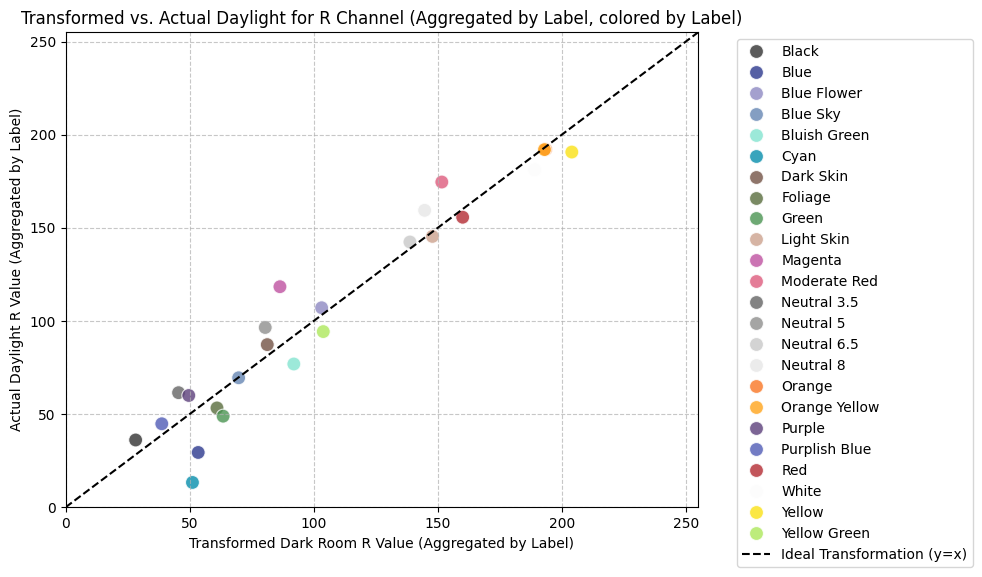

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for plotting aggregated R-channel values
plot_data_r_agg = pd.DataFrame({
    'actual_daylight_R': daylight_rgb_aggregated[:, 0],
    'transformed_darkroom_R': transformed_darkroom_rgb_aggregated[:, 0],
    'label': df_aggregated_by_label['label']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='transformed_darkroom_R',
    y='actual_daylight_R',
    data=plot_data_r_agg,
    alpha=0.8,
    hue='label', # Color dots by label
    palette=label_to_hex_color, # Use the custom palette for true color representation
    s=100 # Make dots larger since there are fewer (one per label)
)

# Reference line y=x (ideal transformation)
plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

plt.xlabel('Transformed Dark Room R Value (Aggregated by Label)')
plt.ylabel('Actual Daylight R Value (Aggregated by Label)')
plt.title('Transformed vs. Actual Daylight for R Channel (Aggregated by Label, colored by Label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.tight_layout()
plt.show()

In [201]:
daylight_rgb_values[0]

array([86, 58, 46])

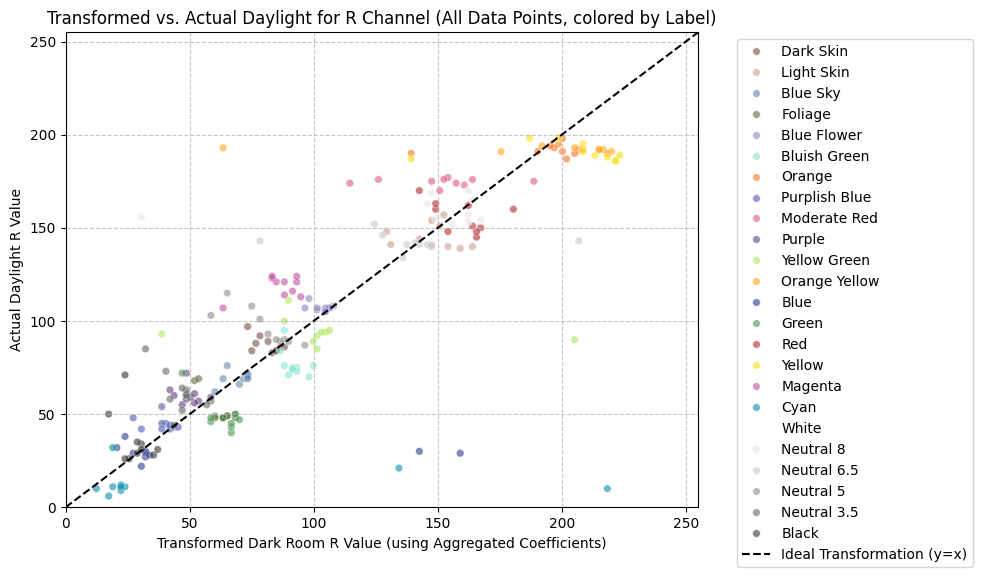

In [202]:
# Apply the new optimal transformation (from aggregated data) to the original individual darkroom values
transformed_darkroom_rgb_values_new = linear_transformation_model(darkroom_rgb_values, optimal_params_aggregated)

# Create a DataFrame for plotting all individual R-channel values
plot_data_r_individual = pd.DataFrame({
    'actual_daylight_R': daylight_rgb_values[:, 0],
    'transformed_darkroom_R': transformed_darkroom_rgb_values_new[:, 0],
    'label': df_merged_r2['label'] # Use the original df_merged_r2 for labels to match individual points
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='transformed_darkroom_R',
    y='actual_daylight_R',
    data=plot_data_r_individual,
    alpha=0.6,
    hue='label',
    palette=label_to_hex_color,
    s=30
)

# Reference line y=x (ideal transformation)
plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

plt.xlabel('Transformed Dark Room R Value (using Aggregated Coefficients)')
plt.ylabel('Actual Daylight R Value')
plt.title('Transformed vs. Actual Daylight for R Channel (All Data Points, colored by Label)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.tight_layout()
plt.show()

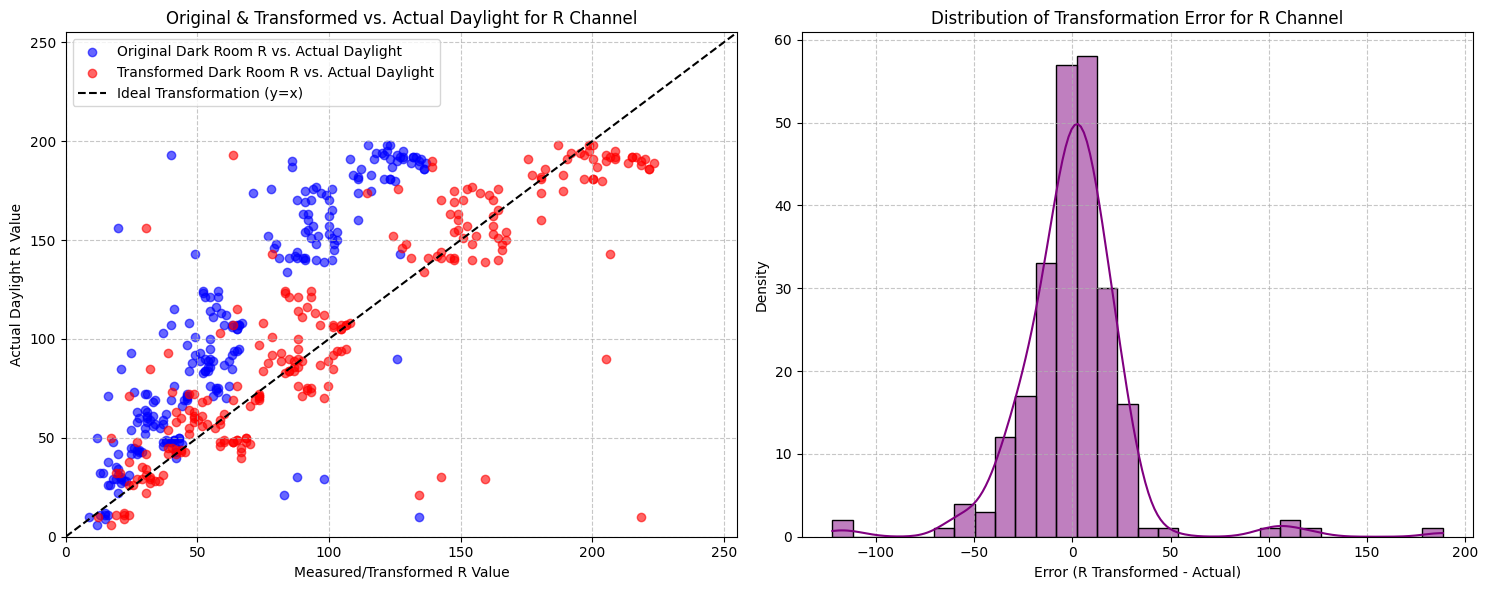

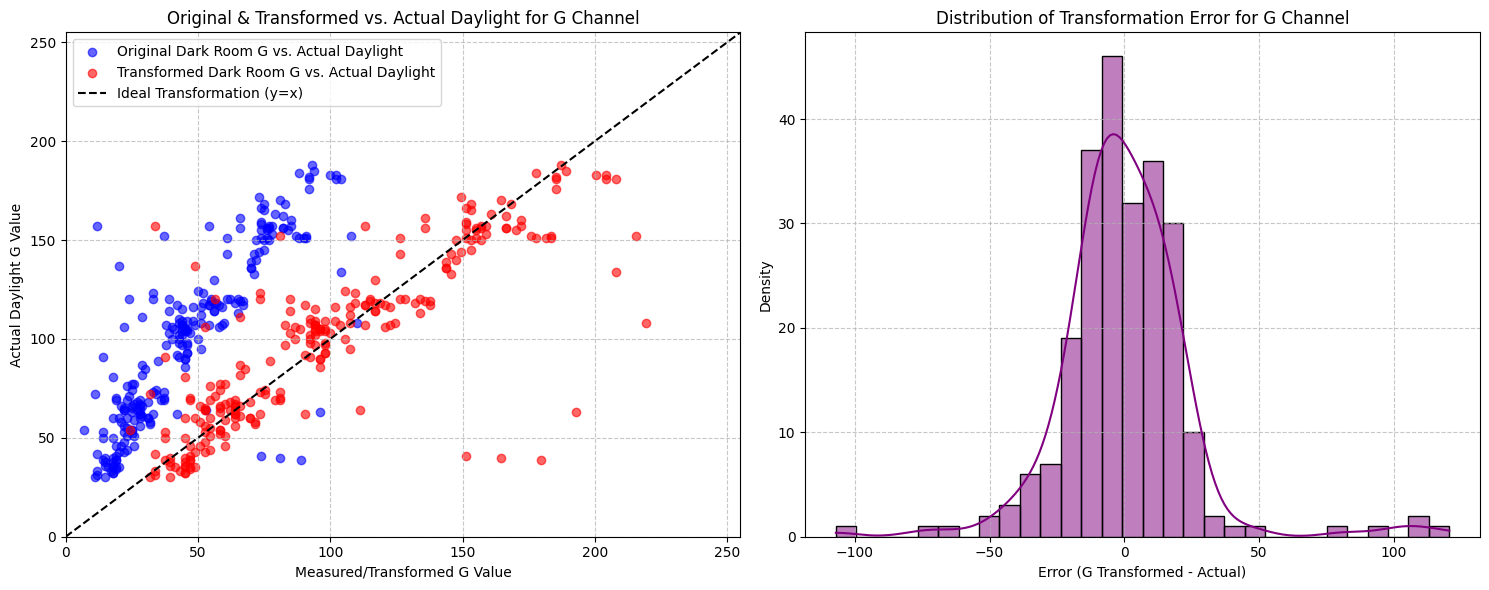

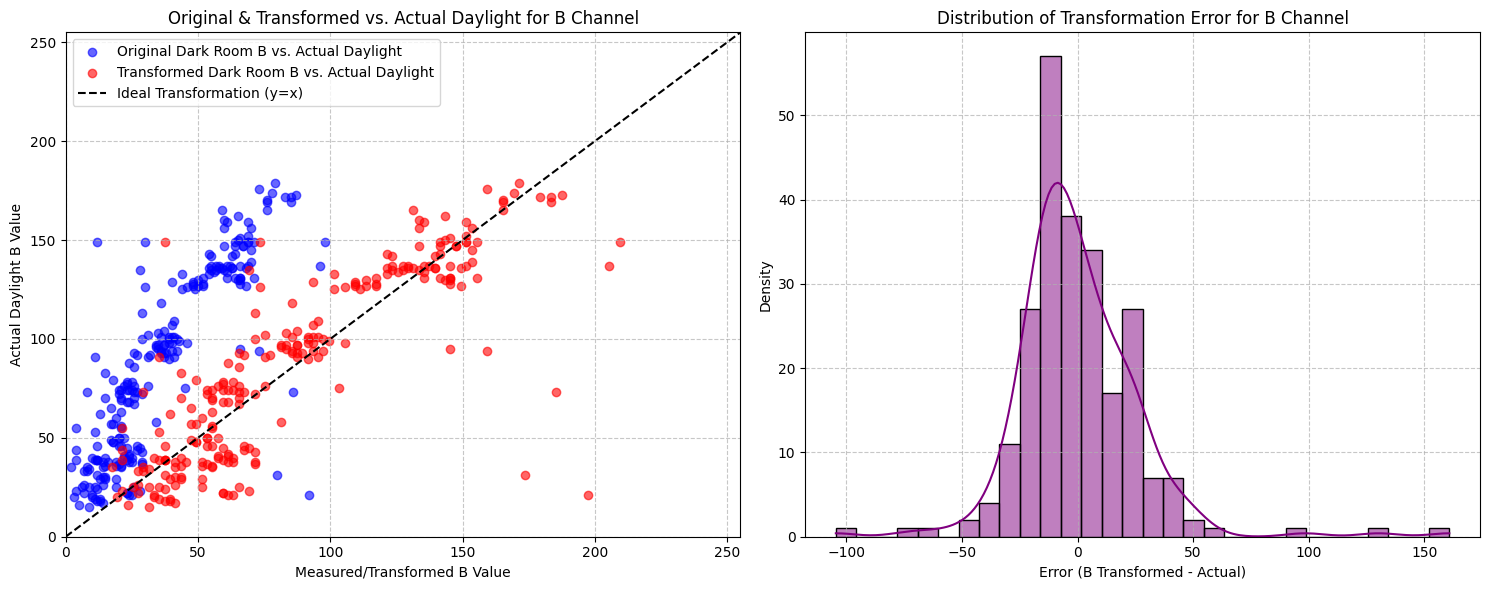

In [203]:
channels = ['R', 'G', 'B']

for i, channel in enumerate(channels):
    plt.figure(figsize=(15, 6))

    # Subplot 1: Scatter plot comparison
    plt.subplot(1, 2, 1)

    # Original Dark Room vs. Actual Daylight
    plt.scatter(
        darkroom_rgb_values[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Original Dark Room {channel} vs. Actual Daylight',
        color='blue'
    )

    # Transformed Dark Room vs. Actual Daylight
    plt.scatter(
        transformed_darkroom_rgb_values_new[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Transformed Dark Room {channel} vs. Actual Daylight',
        color='red'
    )

    # Reference line y=x
    min_val = min(daylight_rgb_values[:, i].min(), darkroom_rgb_values[:, i].min())
    max_val = max(daylight_rgb_values[:, i].max(), darkroom_rgb_values[:, i].max())
    plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

    plt.xlabel(f'Measured/Transformed {channel} Value')
    plt.ylabel(f'Actual Daylight {channel} Value')
    plt.title(f'Original & Transformed vs. Actual Daylight for {channel} Channel')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 255)
    plt.ylim(0, 255)

    # Subplot 2: Error distribution
    plt.subplot(1, 2, 2)
    error = transformed_darkroom_rgb_values[:, i] - daylight_rgb_values[:, i]
    sns.histplot(error, kde=True, color='purple', bins=30)

    plt.xlabel(f'Error ({channel} Transformed - Actual)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Transformation Error for {channel} Channel')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig('Darkroom versus Daylight.png')
    plt.tight_layout()
    plt.show()

In [204]:
r_channel_index = 0 # R channel is at index 0

# Calculate the difference for the R channel
difference_r = transformed_darkroom_rgb_values[:, r_channel_index] - daylight_rgb_values[:, r_channel_index]

# Identify indices where the transformed R value is significantly higher than the actual R value
outlier_threshold = 50
outlier_indices = np.where(difference_r > outlier_threshold)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outlier points for the R channel where transformed_R - actual_R > {outlier_threshold}:")
    outlier_info = df_merged_r2.iloc[outlier_indices].copy()
    outlier_info['transformed_darkroom_R'] = transformed_darkroom_rgb_values[outlier_indices, r_channel_index]
    display(outlier_info[['sample_number', 'capture_index', 'darkroom_r2_R', 'transformed_darkroom_R', 'daylight_r2_R']])
else:
    print(f"No outlier points found for the R channel where transformed_R - actual_R > {outlier_threshold}.")

outlier_data_R = outlier_info


Found 5 outlier points for the R channel where transformed_R - actual_R > 50:


,sample_number,capture_index,darkroom_r2_R,transformed_darkroom_R,daylight_r2_R
105,11,5,126,187.760562,90
126,13,6,88,136.089544,30
129,13,9,98,149.687180,29
173,18,3,83,129.290725,21
179,18,9,134,198.638671,10


In [205]:
# Get unique sample numbers from the outliers
outlier_sample_numbers = outlier_data_R['sample_number'].unique()

print("Pitch and Roll Comparison for Outlier Samples (R Channel):")
print("----------------------------------------------------------")

for sample_num in outlier_sample_numbers:
    print(f"\nSample Number: {int(sample_num)}")
    # Get all 10 captures for the current sample number from df_darkroom
    sample_captures = df_darkroom[df_darkroom['sample_number'] == sample_num]

    # Get the capture indices that are outliers for this sample
    outlier_capture_indices_for_sample = outlier_data_R[outlier_data_R['sample_number'] == sample_num]['capture_index'].tolist()

    for index, row in sample_captures.iterrows():
        capture_idx = row['capture_index']
        pitch_val = row['pitch']
        roll_val = row['roll']
        is_outlier = ' (OUTLIER)' if capture_idx in outlier_capture_indices_for_sample else ''
        print(f"  Capture Index: {int(capture_idx)}, Pitch: {pitch_val:.2f}, Roll: {roll_val:.2f}{is_outlier}")

Pitch and Roll Comparison for Outlier Samples (R Channel):
----------------------------------------------------------

Sample Number: 11
  Capture Index: 0, Pitch: 4.60, Roll: 16.44
  Capture Index: 1, Pitch: 5.35, Roll: 23.77
  Capture Index: 2, Pitch: 6.28, Roll: 22.87
  Capture Index: 3, Pitch: -17.91, Roll: 1.54
  Capture Index: 4, Pitch: -19.61, Roll: -0.47
  Capture Index: 5, Pitch: 0.77, Roll: -21.79 (OUTLIER)
  Capture Index: 6, Pitch: 13.49, Roll: -3.89
  Capture Index: 7, Pitch: 20.87, Roll: 1.84
  Capture Index: 8, Pitch: 18.11, Roll: 2.75
  Capture Index: 9, Pitch: 7.03, Roll: 1.64

Sample Number: 13
  Capture Index: 0, Pitch: 4.73, Roll: 11.09
  Capture Index: 1, Pitch: 3.30, Roll: 20.84
  Capture Index: 2, Pitch: -14.51, Roll: 0.71
  Capture Index: 3, Pitch: -24.34, Roll: 0.63
  Capture Index: 4, Pitch: -8.51, Roll: -11.68
  Capture Index: 5, Pitch: 0.93, Roll: -21.30
  Capture Index: 6, Pitch: 15.98, Roll: -10.14 (OUTLIER)
  Capture Index: 7, Pitch: 26.35, Roll: -0.56
  

In [206]:
b_channel_index = 2 # B channel is at index 2

# Calculate the difference for the B channel
difference_b = transformed_darkroom_rgb_values[:, b_channel_index] - daylight_rgb_values[:, b_channel_index]

# Identify indices where the transformed B value is significantly higher than the actual B value
outlier_threshold = 50
outlier_indices = np.where(difference_b > outlier_threshold)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outlier points for the B channel where transformed_B - actual_B > {outlier_threshold}:")
    outlier_info = df_merged_r2.iloc[outlier_indices].copy()
    outlier_info['transformed_darkroom_B'] = transformed_darkroom_rgb_values[outlier_indices, b_channel_index]
    display(outlier_info[['sample_number', 'capture_index', 'darkroom_r2_B', 'transformed_darkroom_B', 'daylight_r2_B']])
else:
    print(f"No outlier points found for the B channel where transformed_B - actual_B > {outlier_threshold}.")

outlier_data_B = outlier_info

Found 5 outlier points for the B channel where transformed_B - actual_B > 50:


,sample_number,capture_index,darkroom_r2_B,transformed_darkroom_B,daylight_r2_B
82,9,2,86,171.476591,73
105,11,5,92,181.774510,21
129,13,9,73,149.164434,94
142,15,2,80,161.178673,31
179,18,9,96,188.639789,137


In [207]:
# Get unique sample numbers from the outliers
outlier_sample_numbers = outlier_data_B['sample_number'].unique()

print("Pitch and Roll Comparison for Outlier Samples (B Channel):")
print("----------------------------------------------------------")

for sample_num in outlier_sample_numbers:
    print(f"\nSample Number: {int(sample_num)}")
    # Get all 10 captures for the current sample number from df_darkroom
    sample_captures = df_darkroom[df_darkroom['sample_number'] == sample_num]

    # Get the capture indices that are outliers for this sample
    outlier_capture_indices_for_sample = outlier_data_B[outlier_data_B['sample_number'] == sample_num]['capture_index'].tolist()

    for index, row in sample_captures.iterrows():
        capture_idx = row['capture_index']
        pitch_val = row['pitch']
        roll_val = row['roll']
        is_outlier = ' (OUTLIER)' if capture_idx in outlier_capture_indices_for_sample else ''
        print(f"  Capture Index: {int(capture_idx)}, Pitch: {pitch_val:.2f}, Roll: {roll_val:.2f}{is_outlier}")


Pitch and Roll Comparison for Outlier Samples (B Channel):
----------------------------------------------------------

Sample Number: 9
  Capture Index: 0, Pitch: 2.00, Roll: 14.87
  Capture Index: 1, Pitch: 1.96, Roll: 25.53
  Capture Index: 2, Pitch: -8.27, Roll: 2.32 (OUTLIER)
  Capture Index: 3, Pitch: -23.60, Roll: -1.82
  Capture Index: 4, Pitch: -1.15, Roll: -15.71
  Capture Index: 5, Pitch: 5.47, Roll: -26.93
  Capture Index: 6, Pitch: 14.70, Roll: 0.68
  Capture Index: 7, Pitch: 23.58, Roll: 1.69
  Capture Index: 8, Pitch: 25.68, Roll: 1.09
  Capture Index: 9, Pitch: 5.24, Roll: 1.23

Sample Number: 11
  Capture Index: 0, Pitch: 4.60, Roll: 16.44
  Capture Index: 1, Pitch: 5.35, Roll: 23.77
  Capture Index: 2, Pitch: 6.28, Roll: 22.87
  Capture Index: 3, Pitch: -17.91, Roll: 1.54
  Capture Index: 4, Pitch: -19.61, Roll: -0.47
  Capture Index: 5, Pitch: 0.77, Roll: -21.79 (OUTLIER)
  Capture Index: 6, Pitch: 13.49, Roll: -3.89
  Capture Index: 7, Pitch: 20.87, Roll: 1.84
  Capt

In [208]:
g_channel_index = 1 # G channel is at index 1

# Calculate the difference for the G channel
difference_g = transformed_darkroom_rgb_values[:, g_channel_index] - daylight_rgb_values[:, g_channel_index]

# Identify indices where the transformed G value is significantly higher than the actual G value
outlier_threshold = 50
outlier_indices = np.where(difference_g > outlier_threshold)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outlier points for the G channel where transformed_G - actual_G > {outlier_threshold}:")
    outlier_info = df_merged_r2.iloc[outlier_indices].copy()
    outlier_info['transformed_darkroom_G'] = transformed_darkroom_rgb_values[outlier_indices, g_channel_index]
    display(outlier_info[['sample_number', 'capture_index', 'darkroom_r2_G', 'transformed_darkroom_G', 'daylight_r2_G']])
else:
    print(f"No outlier points found for the G channel where transformed_G - actual_G > {outlier_threshold}.")

outlier_data_G = outlier_info

Found 5 outlier points for the G channel where transformed_G - actual_G > 50:


,sample_number,capture_index,darkroom_r2_G,transformed_darkroom_G,daylight_r2_G
82,9,2,96,169.529402,63
126,13,6,74,138.212672,41
129,13,9,81,148.177086,40
142,15,2,89,159.564988,39
179,18,9,110,189.458230,108


In [209]:
# Get unique sample numbers from the outliers
outlier_sample_numbers = outlier_data_G['sample_number'].unique()

print("Pitch and Roll Comparison for Outlier Samples (B Channel):")
print("----------------------------------------------------------")

for sample_num in outlier_sample_numbers:
    print(f"\nSample Number: {int(sample_num)}")
    # Get all 10 captures for the current sample number from df_darkroom
    sample_captures = df_darkroom[df_darkroom['sample_number'] == sample_num]

    # Get the capture indices that are outliers for this sample
    outlier_capture_indices_for_sample = outlier_data_G[outlier_data_G['sample_number'] == sample_num]['capture_index'].tolist()

    for index, row in sample_captures.iterrows():
        capture_idx = row['capture_index']
        pitch_val = row['pitch']
        roll_val = row['roll']
        is_outlier = ' (OUTLIER)' if capture_idx in outlier_capture_indices_for_sample else ''
        print(f"  Capture Index: {int(capture_idx)}, Pitch: {pitch_val:.2f}, Roll: {roll_val:.2f}{is_outlier}")


Pitch and Roll Comparison for Outlier Samples (B Channel):
----------------------------------------------------------

Sample Number: 9
  Capture Index: 0, Pitch: 2.00, Roll: 14.87
  Capture Index: 1, Pitch: 1.96, Roll: 25.53
  Capture Index: 2, Pitch: -8.27, Roll: 2.32 (OUTLIER)
  Capture Index: 3, Pitch: -23.60, Roll: -1.82
  Capture Index: 4, Pitch: -1.15, Roll: -15.71
  Capture Index: 5, Pitch: 5.47, Roll: -26.93
  Capture Index: 6, Pitch: 14.70, Roll: 0.68
  Capture Index: 7, Pitch: 23.58, Roll: 1.69
  Capture Index: 8, Pitch: 25.68, Roll: 1.09
  Capture Index: 9, Pitch: 5.24, Roll: 1.23

Sample Number: 13
  Capture Index: 0, Pitch: 4.73, Roll: 11.09
  Capture Index: 1, Pitch: 3.30, Roll: 20.84
  Capture Index: 2, Pitch: -14.51, Roll: 0.71
  Capture Index: 3, Pitch: -24.34, Roll: 0.63
  Capture Index: 4, Pitch: -8.51, Roll: -11.68
  Capture Index: 5, Pitch: 0.93, Roll: -21.30
  Capture Index: 6, Pitch: 15.98, Roll: -10.14 (OUTLIER)
  Capture Index: 7, Pitch: 26.35, Roll: -0.56
  C

In [210]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each RGB channel before transformation
initial_mse_r = mean_squared_error(daylight_rgb_values[:, 0], darkroom_rgb_values[:, 0])
initial_mse_g = mean_squared_error(daylight_rgb_values[:, 1], darkroom_rgb_values[:, 1])
initial_mse_b = mean_squared_error(daylight_rgb_values[:, 2], darkroom_rgb_values[:, 2])

print(f"Initial MSE for R channel (Darkroom vs. Daylight): {initial_mse_r:.4f}")
print(f"Initial MSE for G channel (Darkroom vs. Daylight): {initial_mse_g:.4f}")
print(f"Initial MSE for B channel (Darkroom vs. Daylight): {initial_mse_b:.4f}")

# Calculate overall average initial MSE
initial_overall_average_mse = (initial_mse_r + initial_mse_g + initial_mse_b) / 3
print(f"Initial Overall Average MSE (Darkroom vs. Daylight): {initial_overall_average_mse:.4f}")

Initial MSE for R channel (Darkroom vs. Daylight): 2566.8417
Initial MSE for G channel (Darkroom vs. Daylight): 3449.1375
Initial MSE for B channel (Darkroom vs. Daylight): 3472.1625
Initial Overall Average MSE (Darkroom vs. Daylight): 3162.7139


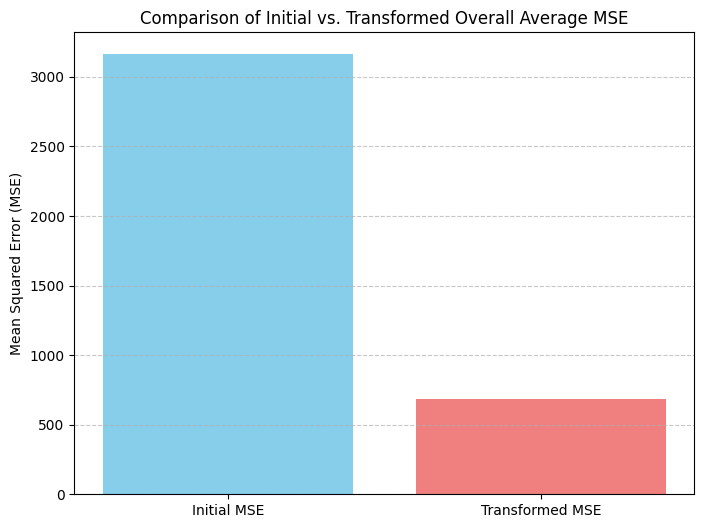

In [211]:
labels = ['Initial MSE', 'Transformed MSE']
mse_values = [initial_overall_average_mse, overall_average_mse]

plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'lightcoral'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Initial vs. Transformed Overall Average MSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [212]:
def polynomial_transformation_model(darkroom_rgb, params):
    num_coeffs_per_channel = len(params) // 3

    predicted_rgb = np.zeros_like(darkroom_rgb, dtype=float)

    for i in range(3): # Iterate through R, G, B channels
        # Extract coefficients for the current channel
        start_index = i * num_coeffs_per_channel
        end_index = (i + 1) * num_coeffs_per_channel
        channel_coefficients = params[start_index:end_index]

        # Apply polynomial transformation
        predicted_rgb[:, i] = np.polyval(channel_coefficients, darkroom_rgb[:, i])

    # Clip values to be within [0, 255] range
    predicted_rgb = np.clip(predicted_rgb, 0, 255)

    return predicted_rgb

print("Polynomial transformation model function defined.")

Polynomial transformation model function defined.


In [213]:
def polynomial_loss_function(params, darkroom_rgb, daylight_rgb):
    predicted_rgb = polynomial_transformation_model(darkroom_rgb, params)
    mse = mean_squared_error(daylight_rgb, predicted_rgb)
    return mse

print("Polynomial loss function defined.")

Polynomial loss function defined.


In [214]:
# results_polynomial_optimization = []

# for degree in range(1, 11): # Iterate from degree 1 to 10
#     print(f"\nOptimizing for polynomial degree: {degree}")
#     num_coeffs_per_channel = degree + 1

#     # Initialize parameters. For simplicity, initialize all to 0.
#     # For degree 1 (linear), it means 3 slopes and 3 intercepts.
#     # For higher degrees, it's degree+1 coefficients per channel.
#     initial_params = [0.0] * (3 * num_coeffs_per_channel)

#     # Special initialization for linear terms (degree 1) if desired,
#     # otherwise general initialization to 0 is fine.
#     if degree == 1:
#         initial_params = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0] # [slope_r, slope_g, slope_b, intercept_r, intercept_g, intercept_b]

#     # Define bounds for parameters. Adjust as needed.
#     # Using (-50.0, 50.0) as a general bound for coefficients to prevent extreme values.
#     bounds_per_coeff = (-50.0, 50.0)
#     # For the highest order term, it's generally good to keep it close to 0 to prevent large oscillations.
#     # For lower order terms (especially linear and constant), wider bounds might be appropriate.
#     bounds = [bounds_per_coeff] * (3 * num_coeffs_per_channel)

#     # Perform optimization
#     result = minimize(
#         polynomial_loss_function,
#         initial_params,
#         args=(darkroom_rgb_aggregated, daylight_rgb_aggregated),
#         method='L-BFGS-B',
#         bounds=bounds
#     )

#     optimal_params_poly = result.x
#     min_mse_poly = result.fun

#     print(f"  Optimal Parameters (first 6): {optimal_params_poly[:6]}")
#     print(f"  Minimum MSE: {min_mse_poly:.4f}")

#     results_polynomial_optimization.append({
#         'degree': degree,
#         'mse': min_mse_poly,
#         'optimal_params': optimal_params_poly.tolist()
#     })

# print("\nPolynomial optimization completed for all degrees (1-10).")
# # Display the results
# for res in results_polynomial_optimization:
#     print(f"Degree: {res['degree']}, MSE: {res['mse']:.4f}")

In [215]:
# Aggregate data by label for the new optimization objective
df_aggregated_by_label = df_merged_r2.groupby('label').mean(numeric_only=True).reset_index()

# Extract aggregated RGB values
darkroom_rgb_aggregated = df_aggregated_by_label[['darkroom_r2_R', 'darkroom_r2_G', 'darkroom_r2_B']].values
daylight_rgb_aggregated = df_aggregated_by_label[['daylight_r2_R', 'daylight_r2_G', 'daylight_r2_B']].values

results_polynomial_optimization = []

for degree in range(1, 11): # Iterate from degree 1 to 10
    print(f"\nOptimizing for polynomial degree: {degree}")
    num_coeffs_per_channel = degree + 1

    initial_params = [0.0] * (3 * num_coeffs_per_channel)

    if degree == 1:
        initial_params = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0] # [slope_r, slope_g, slope_b, intercept_r, intercept_g, intercept_b]

    # Define bounds for parameters.
    bounds_per_coeff = (-50.0, 50.0)
    bounds = [bounds_per_coeff] * (3 * num_coeffs_per_channel)

    # Perform optimization
    result = minimize(
        polynomial_loss_function,
        initial_params,
        args=(darkroom_rgb_aggregated, daylight_rgb_aggregated),
        method='L-BFGS-B',
        bounds=bounds
    )

    optimal_params_poly = result.x
    min_mse_poly = result.fun

    print(f"  Optimal Parameters (first 6): {optimal_params_poly[:6]}")
    print(f"  Minimum MSE: {min_mse_poly:.4f}")

    results_polynomial_optimization.append({
        'degree': degree,
        'mse': min_mse_poly,
        'optimal_params': optimal_params_poly.tolist()
    })

print("\nPolynomial optimization completed for all degrees (1-10).")
# Display the results
for res in results_polynomial_optimization:
    print(f"Degree: {res['degree']}, MSE: {res['mse']:.4f}")


Optimizing for polynomial degree: 1
  Optimal Parameters (first 6): [ 1.64800229 -2.43887895  1.89192389 11.10621482  2.1578339   7.57180838]
  Minimum MSE: 187.1342

Optimizing for polynomial degree: 2
  Optimal Parameters (first 6): [ 6.31693357e-05  1.59866578e+00  1.12028384e+00 -4.68696994e-03
  2.37299730e+00  1.16157808e+00]
  Minimum MSE: 184.9886

Optimizing for polynomial degree: 3
  Optimal Parameters (first 6): [-1.73422093e-05  2.04075831e-03  1.59563322e+00  4.23221489e-01
 -1.53474806e-04  1.49180280e-02]
  Minimum MSE: 187.2438

Optimizing for polynomial degree: 4
  Optimal Parameters (first 6): [-4.48474393e-06  6.37520466e-04  6.92973197e-04  6.82340959e-04
  6.39060865e-04 -1.46446283e-05]
  Minimum MSE: 942.2532

Optimizing for polynomial degree: 5
  Optimal Parameters (first 6): [1.83416651e-08 3.97101530e-07 4.40859435e-07 4.42157874e-07
 4.42187547e-07 1.96828816e-07]
  Minimum MSE: 4393.3177

Optimizing for polynomial degree: 6
  Optimal Parameters (first 6): [

In [216]:
min_mse = float('inf')
best_degree = None
best_optimal_params = None

for res in results_polynomial_optimization:
    if res['mse'] < min_mse:
        min_mse = res['mse']
        best_degree = res['degree']
        best_optimal_params = res['optimal_params']

print(f"Best Polynomial Degree: {best_degree}")
print(f"Minimum MSE for best degree: {min_mse:.4f}")


Best Polynomial Degree: 2
Minimum MSE for best degree: 184.9886


In [217]:
from sklearn.metrics import r2_score

# Apply the best polynomial transformation to the aggregated darkroom values
transformed_darkroom_rgb_aggregated_best = polynomial_transformation_model(darkroom_rgb_aggregated, best_optimal_params)

# Calculate R-squared values for each RGB channel
r2_r_best = r2_score(daylight_rgb_aggregated[:, 0], transformed_darkroom_rgb_aggregated_best[:, 0])
r2_g_best = r2_score(daylight_rgb_aggregated[:, 1], transformed_darkroom_rgb_aggregated_best[:, 1])
r2_b_best = r2_score(daylight_rgb_aggregated[:, 2], transformed_darkroom_rgb_aggregated_best[:, 2])

print(f"Best Polynomial Degree: {best_degree}")
print(f"Minimum MSE for best degree: {min_mse:.4f}")
print(f"Optimal Parameters for Degree {best_degree}: {best_optimal_params}")
print(f"R-squared for R channel (Best Degree): {r2_r_best:.4f}")
print(f"R-squared for G channel (Best Degree): {r2_g_best:.4f}")
print(f"R-squared for B channel (Best Degree): {r2_b_best:.4f}")

Best Polynomial Degree: 2
Minimum MSE for best degree: 184.9886
Optimal Parameters for Degree 2: [6.316933571055174e-05, 1.5986657833226592, 1.1202838395904255, -0.0046869699395071, 2.372997303639123, 1.1615780792397543, -0.0047584858202742155, 2.556793848114354, 1.1883380603072835]
R-squared for R channel (Best Degree): 0.9285
R-squared for G channel (Best Degree): 0.9409
R-squared for B channel (Best Degree): 0.8975


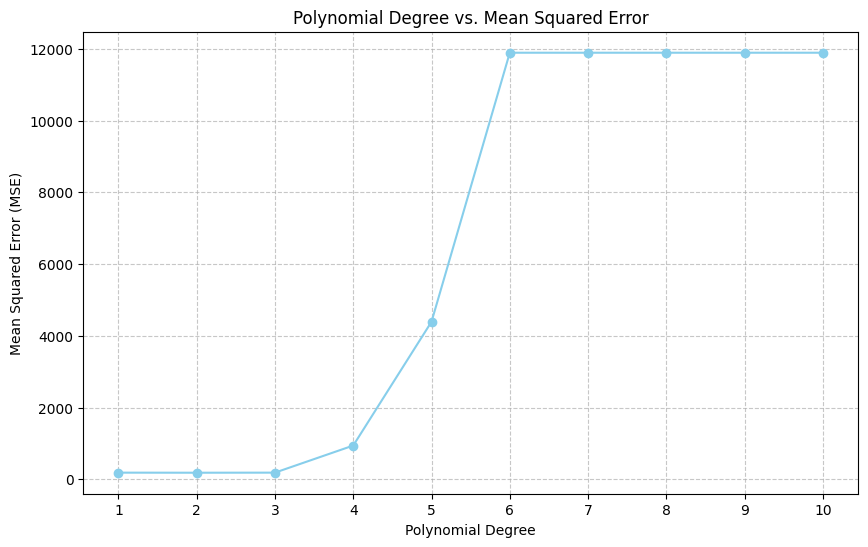

In [218]:
degrees = [res['degree'] for res in results_polynomial_optimization]
mses = [res['mse'] for res in results_polynomial_optimization]

plt.figure(figsize=(10, 6))
plt.plot(degrees, mses, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Polynomial Degree vs. Mean Squared Error')
plt.xticks(degrees) # Ensure all degrees are shown on the x-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

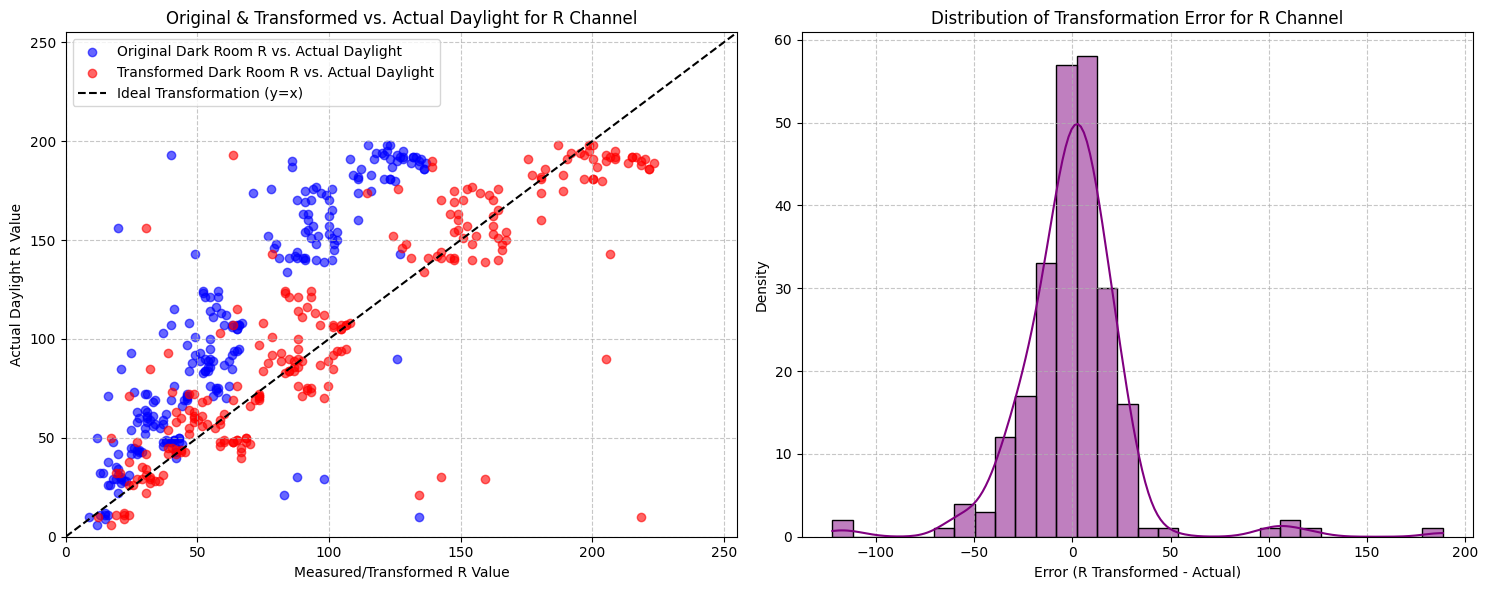

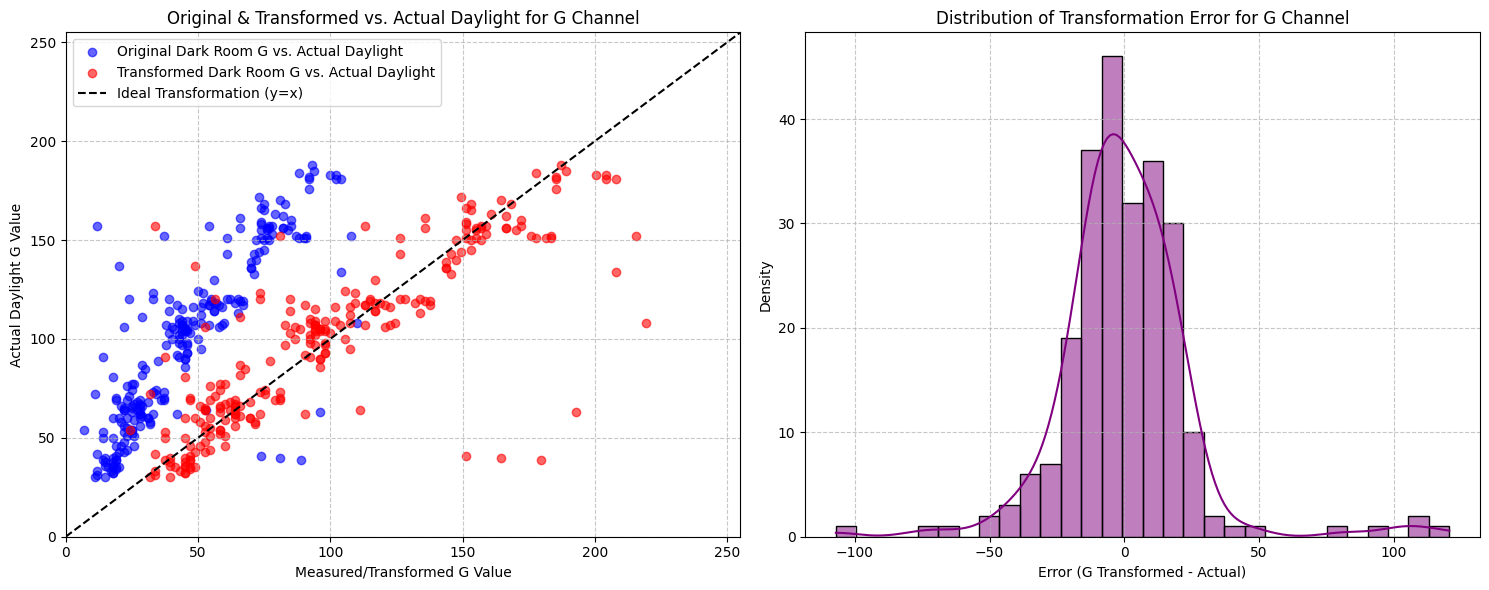

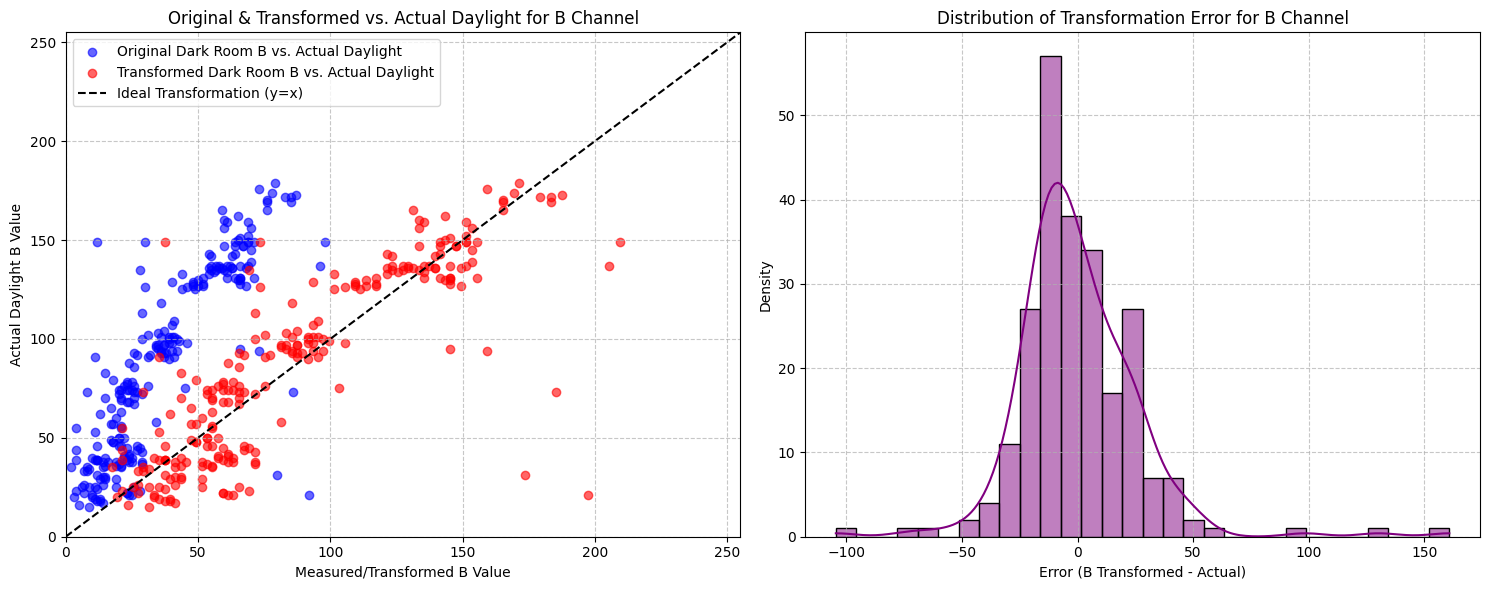

In [219]:
channels = ['R', 'G', 'B']

for i, channel in enumerate(channels):
    plt.figure(figsize=(15, 6))

    # Subplot 1: Scatter plot comparison
    plt.subplot(1, 2, 1)

    # Original Dark Room vs. Actual Daylight
    plt.scatter(
        darkroom_rgb_values[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Original Dark Room {channel} vs. Actual Daylight',
        color='blue'
    )

    # Transformed Dark Room vs. Actual Daylight
    plt.scatter(
        transformed_darkroom_rgb_values_new[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Transformed Dark Room {channel} vs. Actual Daylight',
        color='red'
    )

    # Reference line y=x
    min_val = min(daylight_rgb_values[:, i].min(), darkroom_rgb_values[:, i].min())
    max_val = max(daylight_rgb_values[:, i].max(), darkroom_rgb_values[:, i].max())
    plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

    plt.xlabel(f'Measured/Transformed {channel} Value')
    plt.ylabel(f'Actual Daylight {channel} Value')
    plt.title(f'Original & Transformed vs. Actual Daylight for {channel} Channel')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 255)
    plt.ylim(0, 255)

    # Subplot 2: Error distribution
    plt.subplot(1, 2, 2)
    error = transformed_darkroom_rgb_values[:, i] - daylight_rgb_values[:, i]
    sns.histplot(error, kde=True, color='purple', bins=30)

    plt.xlabel(f'Error ({channel} Transformed - Actual)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Transformation Error for {channel} Channel')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig('Darkroom versus Daylight.png')
    plt.tight_layout()
    plt.show()

## Comparison of Original vs. Polynomial Transformed vs. Actual Daylight (Degree 2)

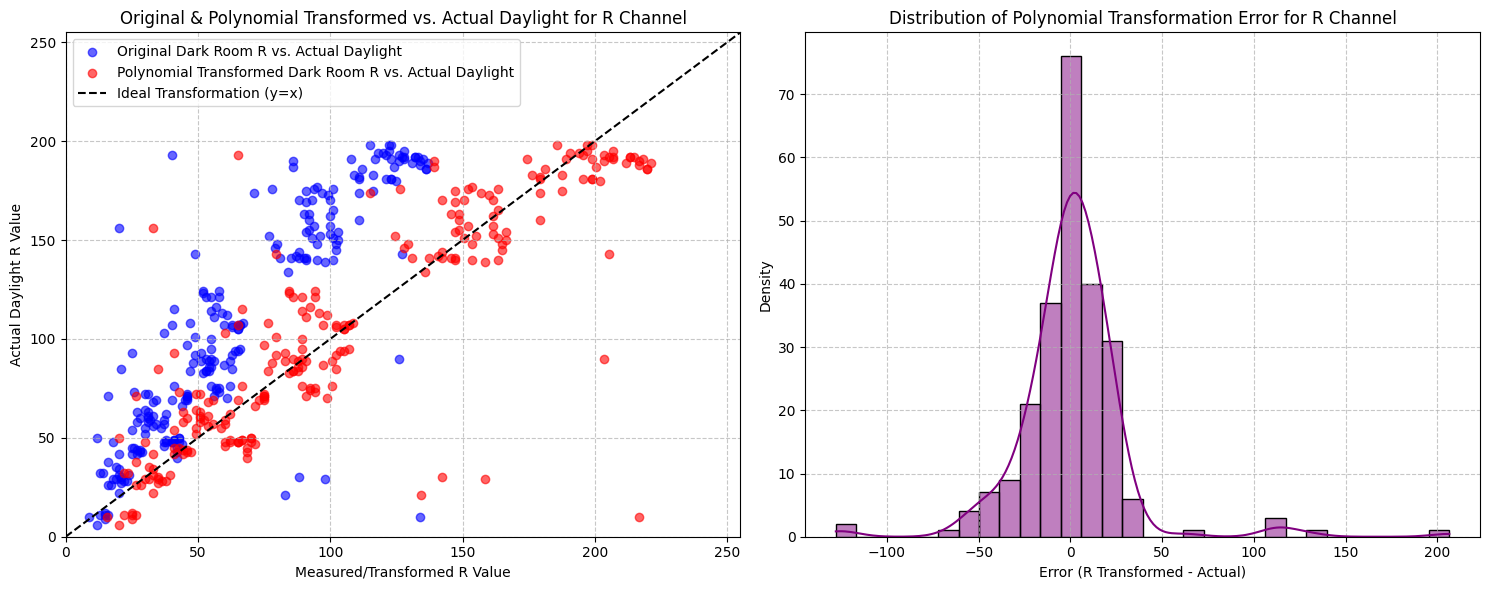

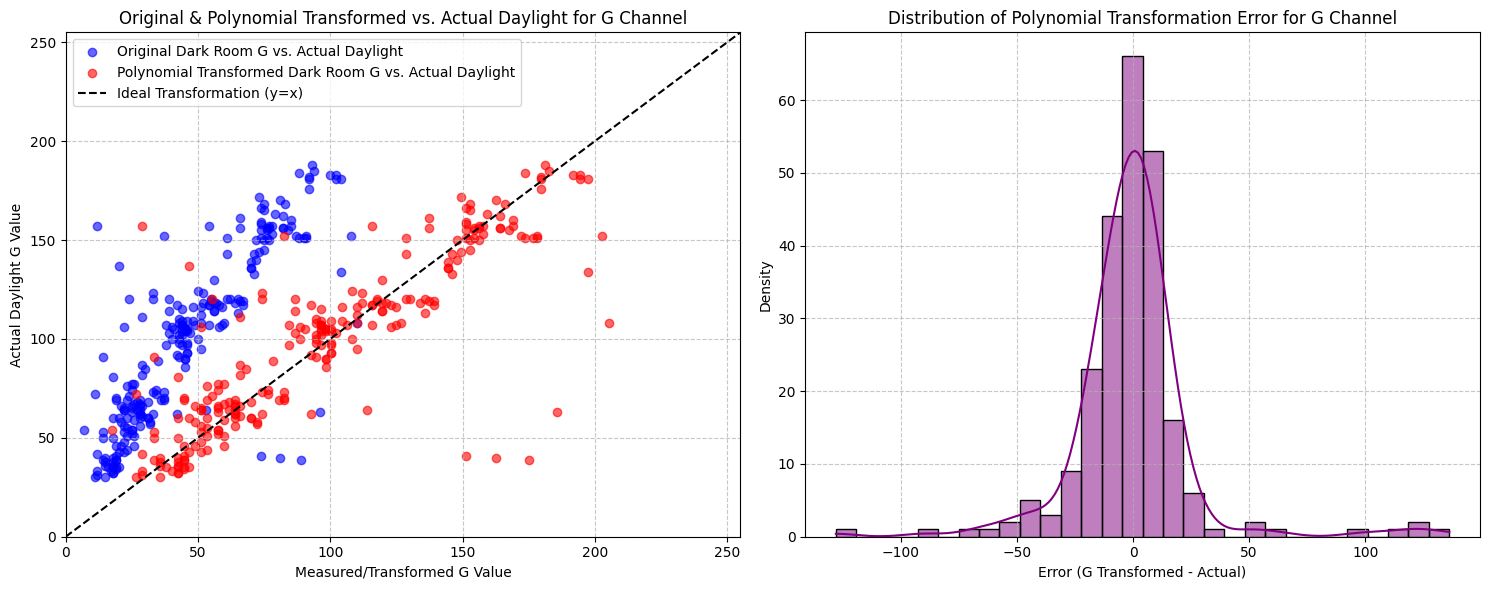

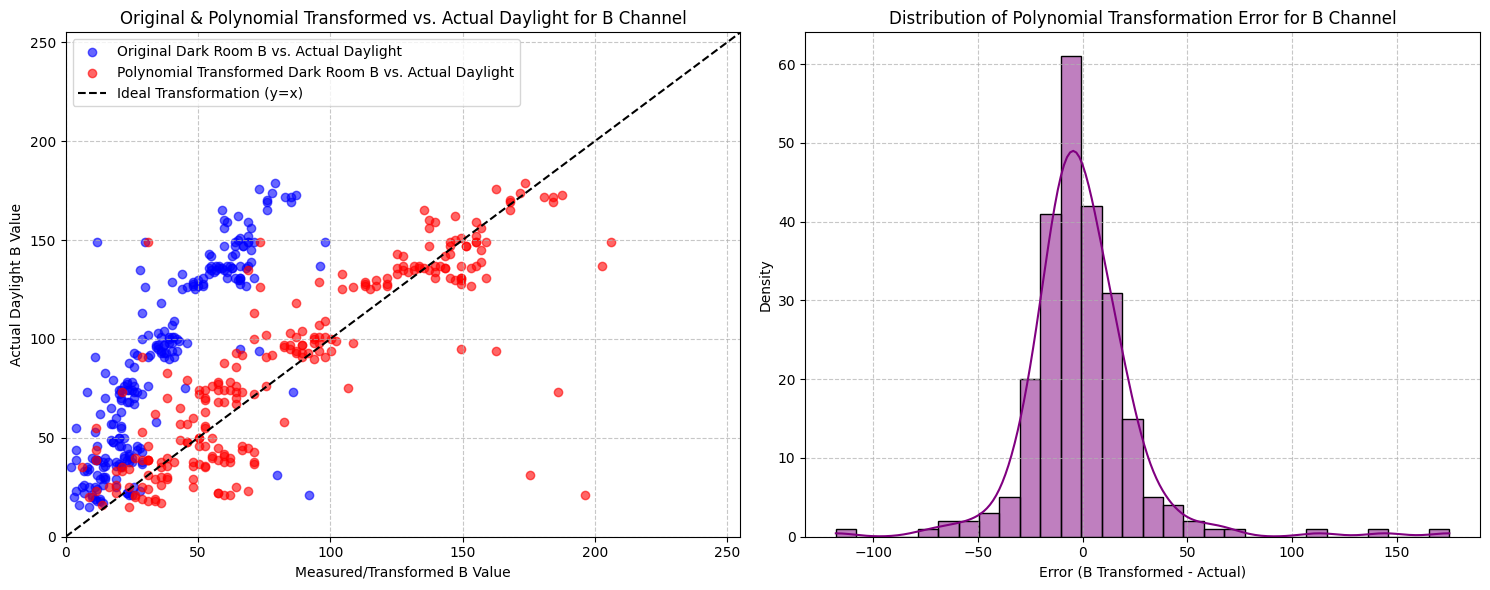

In [220]:
channels = ['R', 'G', 'B']

# Apply the best polynomial transformation (degree 2) to the original individual darkroom values
transformed_darkroom_rgb_values_poly = polynomial_transformation_model(darkroom_rgb_values, best_optimal_params)

for i, channel in enumerate(channels):
    plt.figure(figsize=(15, 6))

    # Subplot 1: Scatter plot comparison
    plt.subplot(1, 2, 1)

    # Original Dark Room vs. Actual Daylight
    plt.scatter(
        darkroom_rgb_values[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Original Dark Room {channel} vs. Actual Daylight',
        color='blue'
    )

    # Polynomial Transformed Dark Room vs. Actual Daylight
    plt.scatter(
        transformed_darkroom_rgb_values_poly[:, i],
        daylight_rgb_values[:, i],
        alpha=0.6,
        label=f'Polynomial Transformed Dark Room {channel} vs. Actual Daylight',
        color='red'
    )

    # Reference line y=x
    min_val = min(daylight_rgb_values[:, i].min(), darkroom_rgb_values[:, i].min())
    max_val = max(daylight_rgb_values[:, i].max(), darkroom_rgb_values[:, i].max())
    plt.plot([0, 255], [0, 255], 'k--', label='Ideal Transformation (y=x)')

    plt.xlabel(f'Measured/Transformed {channel} Value')
    plt.ylabel(f'Actual Daylight {channel} Value')
    plt.title(f'Original & Polynomial Transformed vs. Actual Daylight for {channel} Channel')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 255)
    plt.ylim(0, 255)

    # Subplot 2: Error distribution
    plt.subplot(1, 2, 2)
    error = transformed_darkroom_rgb_values_poly[:, i] - daylight_rgb_values[:, i] # Use polynomial transformed values for error
    sns.histplot(error, kde=True, color='purple', bins=30)

    plt.xlabel(f'Error ({channel} Transformed - Actual)')
    plt.ylabel('Density')
    plt.title(f'Distribution of Polynomial Transformation Error for {channel} Channel')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig(f'Polynomial Transformation Comparison {channel}.png')
    plt.tight_layout()
    plt.show()

## KDE Plot of Error Distributions: Uncorrected vs. Polynomial Transformed

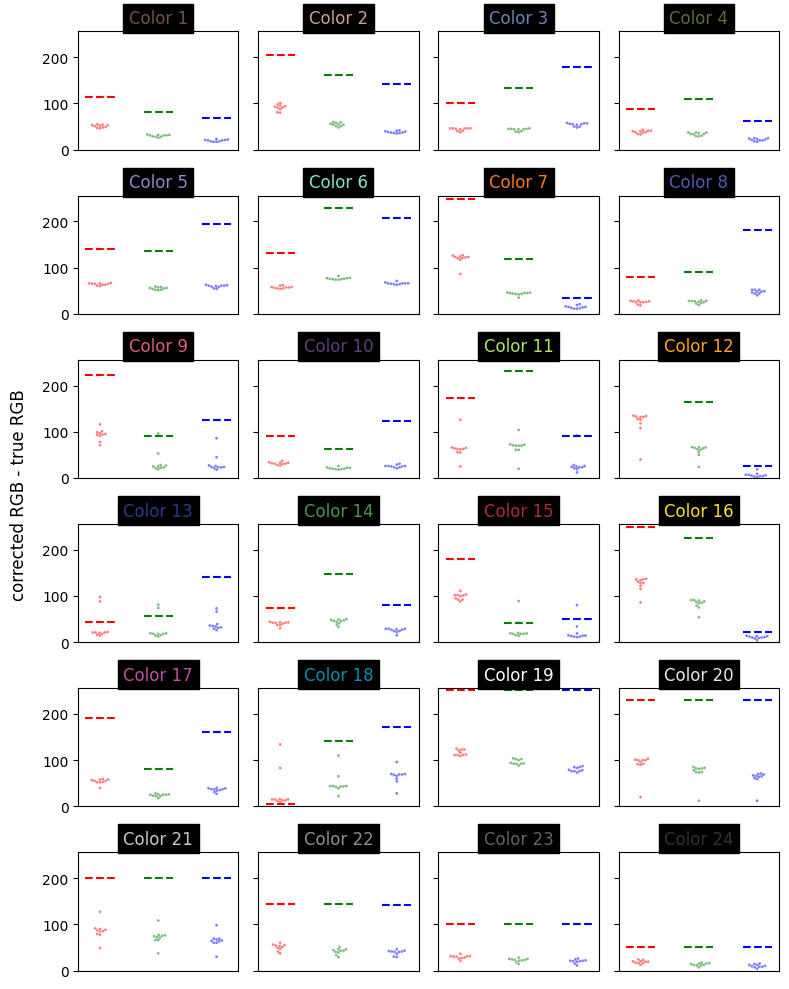

In [221]:
fig, axs = plot_error_dist(df_darkroom, r=2)

In [222]:
df_transformed = df_darkroom.copy()
df_transformed['color_r2_R'] = transformed_darkroom_rgb_values[:, 0]
df_transformed['color_r2_G'] = transformed_darkroom_rgb_values[:, 1]
df_transformed['color_r2_B'] = transformed_darkroom_rgb_values[:, 2]
df_transformed

,session_name,sample_number,capture_index,lighting_condition,reflective_surface,pitch,roll,white_r0_R,white_r0_G,white_r0_B,...,avg_color_r2_B,avg_correction_r2_R,avg_correction_r2_G,avg_correction_r2_B,avg_color_r4_R,avg_color_r4_G,avg_color_r4_B,avg_correction_r4_R,avg_correction_r4_G,avg_correction_r4_B
0,Tai4,1,0,7,False,8.933808,1.934297,126,104,93,...,19.7,103.5,74.2,54.1,51.2,30.4,20.0,104.3,74.9,54.8
1,Tai4,1,1,7,False,6.390318,19.419663,130,108,95,...,19.7,103.5,74.2,54.1,51.2,30.4,20.0,104.3,74.9,54.8
2,Tai4,1,2,7,False,5.482736,14.253509,125,105,94,...,19.7,103.5,74.2,54.1,51.2,30.4,20.0,104.3,74.9,54.8
3,Tai4,1,3,7,False,-5.939599,5.399887,122,100,89,...,19.7,103.5,74.2,54.1,51.2,30.4,20.0,104.3,74.9,54.8
4,Tai4,1,4,7,False,-14.766224,1.748439,117,95,84,...,19.7,103.5,74.2,54.1,51.2,30.4,20.0,104.3,74.9,54.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Tai4,24,5,7,False,0.200593,-17.112985,120,100,89,...,9.9,37.8,31.9,27.1,19.0,13.3,9.9,38.5,32.7,27.1
236,Tai4,24,6,7,False,6.392422,-9.268666,125,103,90,...,9.9,37.8,31.9,27.1,19.0,13.3,9.9,38.5,32.7,27.1
237,Tai4,24,7,7,False,18.885840,0.638100,130,108,97,...,9.9,37.8,31.9,27.1,19.0,13.3,9.9,38.5,32.7,27.1
238,Tai4,24,8,7,False,18.153532,2.063432,132,110,99,...,9.9,37.8,31.9,27.1,19.0,13.3,9.9,38.5,32.7,27.1


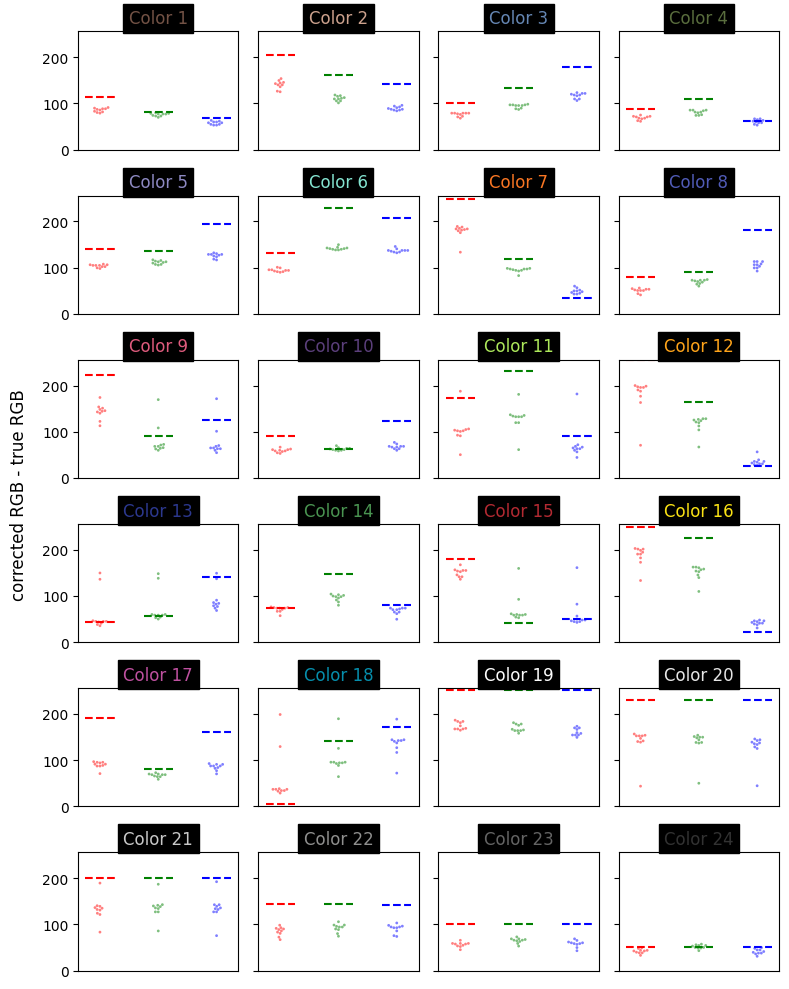

In [223]:
fig, axs = plot_error_dist(df_transformed, r=2) # Boom kaboom kaboom, it works! Look at Color 7 Red near 200 and an increase in Color 3.

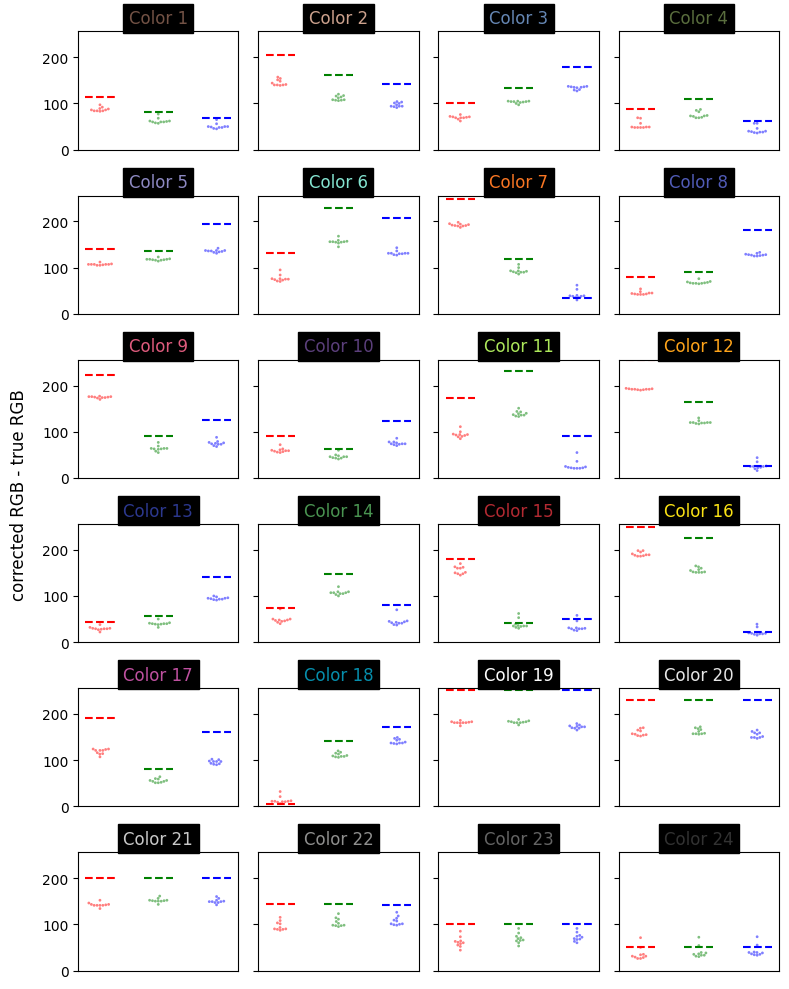

In [224]:
fig, axs = plot_error_dist(df_daylight, r=2)